In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/AmEx/663e2b6d54457_train_data_with_samplefeatures.csv")
batsman_df = pd.read_csv("/content/drive/MyDrive/AmEx/663e2b548c98c_batsman_level_scorecard.csv")
bowler_df = pd.read_csv("/content/drive/MyDrive/AmEx/663e2b2c60743_bowler_level_scorecard.csv")
match_df = pd.read_csv("/content/drive/MyDrive/AmEx/664389efa0868_match_level_scorecard.csv")
test_data = pd.read_csv("/content/drive/MyDrive/AmEx/6644a1e287df6_test_data_with_samplefeatures.csv")

In [ ]:
print(df_train.shape, test_data.shape, batsman_df.shape, bowler_df.shape, match_df.shape)

(948, 23) (271, 21) (24483, 21) (18539, 18) (1689, 30)


In [ ]:
# calculate batsman ability
def calculate_ability_score(batsman_data, player_id, date):
    player_data = batsman_data[(batsman_data['match_dt'] < date) & (batsman_data['batsman_id'] == player_id)]
    if player_data.empty:
        return 0

    avg_runs = player_data['runs'].mean()
    avg_strike_rate = player_data['strike_rate'].mean()
    avg_fours = player_data['Fours'].mean()
    avg_sixes = player_data['Sixes'].mean()
    avg_balls_faced = player_data['balls_faced'].mean()

    runs_weight = 1.5181487193128311
    strike_rate_weight = 0.3083602790196472
    fours_weight = 0.7891150637823163
    sixes_weight = 1.0788199036938635
    balls_faced_weight = 0.4561330128642989

    ability_score = (avg_runs * runs_weight +
                     avg_strike_rate * strike_rate_weight +
                     avg_fours * fours_weight +
                     avg_sixes * sixes_weight +
                     avg_balls_faced * balls_faced_weight)

    return ability_score

In [ ]:
# calculate bowler ability
def calculate_bowler_ability_score(bowler_data, player_id, date):
    player_data = bowler_data[(bowler_data['match_dt'] < date) & (bowler_data['bowler_id'] == player_id)]
    if player_data.empty:
        return 0

    avg_wickets = player_data['wicket_count'].mean()
    avg_runs_conceded = player_data['runs'].mean()
    avg_overs_bowled = player_data['balls_bowled'].mean()
    avg_maiden_overs = player_data['maiden'].mean()
    avg_no_balls = player_data['noballs'].mean()
    avg_wides = player_data['wides'].mean()
    avg_economy_rate = player_data['economy'].mean()
    avg_dot_balls = player_data['dots'].mean()

    wickets_weight = 2.0809690120474973
    runs_conceded_weight = -1.6683077272018556
    overs_bowled_weight = 1.0785331019058244
    maiden_overs_weight = 2.6357976951696878
    no_balls_weight = -0.5321420132185873
    wides_weight =  -0.7445927503032397
    economy_rate_weight =  -0.7620290752804595
    dot_balls_weight = 1.8390768223557485

    ability_score = (avg_wickets * wickets_weight +
                     avg_runs_conceded * runs_conceded_weight +
                     avg_overs_bowled * overs_bowled_weight +
                     avg_maiden_overs * maiden_overs_weight +
                     avg_no_balls * no_balls_weight +
                     avg_wides * wides_weight +
                     avg_economy_rate * economy_rate_weight+
                     avg_dot_balls * dot_balls_weight)
    return ability_score

In [ ]:
def preprocess_batsman(batsman_df):

    # DTYPE CONVERSION

    numeric_columns = ['match id', 'is_batsman_captain', 'is_batsman_keeper', 'inning',
                      'runs', 'balls_faced', 'over_faced_first', 'bowler_id', 'is_bowler_keeper',
                      'is_bowler_captain', 'strike_rate', 'Fours', 'Sixes']
    date_column = 'match_dt'

    # Convert specified columns to float
    batsman_df[numeric_columns] = batsman_df[numeric_columns].astype(float)
    batsman_df['batsman_id']=batsman_df['batsman_id'].astype(int)
    # Convert date column to datetime
    batsman_df[date_column] = pd.to_datetime(batsman_df[date_column])
    data_info_after = batsman_df.dtypes


    #  DROPING OF COLUMNS
    batsman_df=batsman_df.drop("batsman",axis=1)
    return batsman_df

batsman_df = preprocess_batsman(batsman_df)

In [ ]:
def preprocess_bolwers(bowler_df):
  date_column="match_dt"
  bowler_df[date_column] = pd.to_datetime(batsman_df[date_column])
  return bowler_df

bowler_df = preprocess_bolwers(bowler_df)

In [ ]:
print(df_train.shape, test_data.shape, batsman_df.shape, bowler_df.shape, match_df.shape)

(948, 23) (271, 21) (24483, 20) (18539, 18) (1689, 30)


In [ ]:
match_df = preprocess_bolwers(match_df)

In [ ]:
print(df_train.shape, test_data.shape, batsman_df.shape, bowler_df.shape, match_df.shape)

(948, 23) (271, 21) (24483, 20) (18539, 18) (1689, 30)


In [ ]:
def preprocess_train(df_train, match_df):
    # CONVERSION OF DATA_TYPE
    numeric_columns = ['team1_id', 'team2_id', 'ground_id',
                       'team_count_50runs_last15', 'team_winp_last5',
                       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
                       'ground_avg_runs_last15']
    date_column = "match_dt"

    # Convert specified columns to float
    df_train[numeric_columns] = df_train[numeric_columns].astype(float)
    df_train[date_column] = pd.to_datetime(df_train[date_column])

    # Verify the changes (optional, can be removed if not needed)
    df_train_info_after = df_train.dtypes
    df_train_head_after = df_train.head()

    # ONE HOT ENCODING OF THE DATA
    if 'winner' in df_train.columns and 'winner_id' in df_train.columns:
        df_train['winner'] = (df_train['winner_id'] == df_train['team1_id']).astype('float64')

    df_train['toss winner'] = (df_train['toss winner'] == df_train['team1']).astype('float64')
    df_train['toss decision'] = (df_train['toss decision'] == 'bat').astype('float64')

    # CREATING NECESSARY COLUMNS
    if 'team1_roster_ids_bowlers' not in df_train.columns:
        df_train['team1_roster_ids_bowlers'] = df_train['team1_roster_ids'].copy()

    if 'team2_roster_ids_bowlers' not in df_train.columns:
        df_train['team2_roster_ids_bowlers'] = df_train['team2_roster_ids'].copy()

    # Apply the conversion to team rosters
    new_column_names = [
        'top_bowler1_team1', 'top_bowler2_team1', 'top_bowler3_team1',
        'top_bowler1_team2', 'top_bowler2_team2', 'top_bowler3_team2',
        'top_batsman1_team1', 'top_batsman2_team1', 'top_batsman3_team1',
        'top_batsman1_team2', 'top_batsman2_team2', 'top_batsman3_team2','Sum_restBowlerAbility_tm1','Sum_restBowlerAbility_tm2'
    ]

    # Create a dictionary with empty lists for new columns (if they don't exist)
    new_columns = {}
    for col_name in new_column_names:
        if col_name not in df_train.columns:  # Check if column already exists
            empty_list = [[] for _ in range(len(df_train))]
            new_columns[col_name] = empty_list

    # Add the new columns using assign (if any)
    if new_columns:  # Check if there are any new columns to add
        df_train = df_train.assign(**new_columns)

    # CONVERTING ROSTERS INTO DICTIONARY
    def convert_to_dict(roster_ids):
        if isinstance(roster_ids, str):  # Check if roster_ids is a string
            ids = roster_ids.split(':')
            return {int(float(id)): 0 for id in ids}
        return roster_ids  # Return as is if it's already a dictionary

    df_train['team1_roster_ids'] = df_train['team1_roster_ids'].apply(convert_to_dict)
    df_train['team2_roster_ids'] = df_train['team2_roster_ids'].apply(convert_to_dict)
    df_train['team1_roster_ids_bowlers'] = df_train['team1_roster_ids'].apply(convert_to_dict)
    df_train['team2_roster_ids_bowlers'] = df_train['team2_roster_ids'].apply(convert_to_dict)

    return df_train

In [ ]:
# FILLING THE BOWLERS ABILITY IN THE DICTIONARIES.
def fill_bowlers(df_train, bowler_df):
    for index, row in tqdm(df_train.iterrows()):
        match_date = row['match_dt']

        team1_roster = row['team1_roster_ids_bowlers']
        for player_id in team1_roster.keys():
            if player_id in bowler_df['bowler_id'].values:  # Check if player_id exists in bowler_df
                ability_score = calculate_bowler_ability_score(bowler_df, player_id, match_date)
                team1_roster[player_id] = ability_score

        team2_roster = row['team2_roster_ids_bowlers']
        for player_id in team2_roster.keys():
            if player_id in bowler_df['bowler_id'].values:  # Check if player_id exists in bowler_df
                ability_score = calculate_bowler_ability_score(bowler_df, player_id, match_date)
                team2_roster[player_id] = ability_score

        # Fill NaN values with 0 in the dictionaries
        team1_roster = {k: (0 if pd.isna(v) else v) for k, v in team1_roster.items()}
        team2_roster = {k: (0 if pd.isna(v) else v) for k, v in team2_roster.items()}

        # Update the columns with the new dictionaries
        df_train.at[index, 'team1_roster_ids_bowlers'] = team1_roster
        df_train.at[index, 'team2_roster_ids_bowlers'] = team2_roster

    # FILLING THE TOP PERFORMANCES COLUMNS FOR BOWLERS AND BATSMEN:
    # Processing bowlers
    for index, row in tqdm(df_train.iterrows()):
        for team in ['team1', 'team2']:
            bowlers_dict = row[f'{team}_roster_ids_bowlers']
            sorted_bowlers = sorted(bowlers_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            top_bowlers_abilities = [bowler[1] for bowler in sorted_bowlers]
            top_bowlers_abilities += [None] * (3 - len(top_bowlers_abilities))  # Fill remaining slots with None if less than 3 bowlers
            for i in range(3):
                df_train.at[index, f'top_bowler{i+1}_{team}'] = top_bowlers_abilities[i]

            # Calculate the sum of abilities of the rest bowlers
            rest_bowlers_abilities = [ability for bowler, ability in bowlers_dict.items() if ability not in top_bowlers_abilities]
            rest_bowlers_sum = sum(rest_bowlers_abilities)
            df_train.at[index, f'Sum_restBowlerAbility_{team}'] = rest_bowlers_sum
    return df_train

In [ ]:
# FILLING THE BATSMEN ABILITY IN THE DICTIONARIES.
def fill_batsmans(df_train,batsman_df):
      for index, row in tqdm(df_train.iterrows()):
          match_date = row['match_dt']

          team1_roster = row['team1_roster_ids']
          for player_id in team1_roster.keys():
              if player_id in batsman_df['batsman_id'].values:  # Check if player_id exists in bowler_df
                  ability_score = calculate_ability_score(batsman_df, player_id, match_date)
                  team1_roster[player_id] = ability_score

          team2_roster = row['team2_roster_ids']
          for player_id in team2_roster.keys():
              if player_id in batsman_df['batsman_id'].values:  # Check if player_id exists in bowler_df
                  ability_score = calculate_ability_score(batsman_df, player_id, match_date)
                  team2_roster[player_id] = ability_score

          team1_roster = {k: (0 if pd.isna(v) else v) for k, v in team1_roster.items()}
          team2_roster = {k: (0 if pd.isna(v) else v) for k, v in team2_roster.items()}

          # Update the columns with the new dictionaries
          df_train.at[index, 'team1_roster_ids'] = team1_roster
          df_train.at[index, 'team2_roster_ids'] = team2_roster

# FILLING THE TOP PERFORMANCES COLUMNS FOR BOWLERS AND BATSMEN:
# Processing Batsmen
      for index, row in df_train.iterrows():
        for team in ['team1', 'team2']:
            batsmans_dict = row[f'{team}_roster_ids']
            sorted_batsmans = sorted(batsmans_dict.items(), key=lambda x: x[1], reverse=True)[:3]
            top_batsmans_abilities = [batsman[1] for batsman in sorted_batsmans]
            top_batsmans_abilities += [None] * (3 - len(top_batsmans_abilities))  # Fill remaining slots with None if less than 3 batsmen
            for i in range(3):
                df_train.at[index, f'top_batsman{i+1}_{team}'] = top_batsmans_abilities[i]


                # Calculate the sum of abilities of the rest bowlers
            rest_batsmans_abilities = [ability for batsman, ability in batsmans_dict.items() if ability not in top_batsmans_abilities]
            rest_batsmans_sum = sum(rest_batsmans_abilities)
            df_train.at[index, f'Sum_restBatsmanAbility_{team}'] = rest_batsmans_sum

      return df_train

In [ ]:
def remove_columns_with_empty_lists(df):
    columns_to_drop = []
    for col in df.columns:
        if df[col].apply(lambda x: x == []).all():
            columns_to_drop.append(col)
    df.drop(columns=columns_to_drop, inplace=True)

    return df

In [ ]:
import pandas as pd
def convert_into_float(df_train):
  # Assuming cols is a list or array containing the column names
  cols = ['top_bowler1_team1', 'top_bowler2_team1', 'top_bowler3_team1',
          'top_bowler1_team2', 'top_bowler2_team2', 'top_bowler3_team2',
          'top_batsman1_team1', 'top_batsman2_team1', 'top_batsman3_team1',
          'top_batsman1_team2', 'top_batsman2_team2', 'top_batsman3_team2']

  # Select the columns to be converted and convert them to float64
  df_train[cols] = df_train[cols].astype(float)
  return df_train

In [ ]:
# venue based inning 1 runs

def calculate_avg_inning1_runs_venue(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize a list to store the calculated averages
    avg_inning1_runs = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        venue = row['venue']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the venue matches and the match date is before the current match date
        venue_matches = match_df[(match_df['venue'] == venue) &
                                 (match_df['match_dt'] < current_match_dt)]

        # Calculate the average runs for the first inning at this venue using past matches only
        if not venue_matches.empty:
            avg_runs = venue_matches['inning1_runs'].mean()
        else:
            avg_runs = float(0.0)  # or you can choose to set a default value, e.g., 0

        # Append the average runs to the list
        avg_inning1_runs.append(avg_runs)

    if 'avg_inning1_runs_venue' not in df_train.columns:
        df_train['avg_inning1_runs_venue'] = pd.Series(avg_inning1_runs, dtype='float64')
    else:
        df_train['avg_inning1_runs_venue'] = df_train['avg_inning1_runs_venue'].astype('float64')

    return df_train

In [ ]:
# venue based inning 2 runs

def calculate_avg_inning2_runs_venue(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize a list to store the calculated averages
    avg_inning2_runs = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        venue = row['venue']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the venue matches and the match date is before the current match date
        venue_matches = match_df[(match_df['venue'] == venue) &
                                 (match_df['match_dt'] < current_match_dt)]

        # Calculate the average runs for the first inning at this venue using past matches only
        if not venue_matches.empty:
            avg_runs = venue_matches['inning2_runs'].mean()
        else:
            avg_runs = float(0.0)  # or you can choose to set a default value, e.g., 0

        # Append the average runs to the list
        avg_inning2_runs.append(avg_runs)

    if 'avg_inning2_runs_venue' not in df_train.columns:
        df_train['avg_inning2_runs_venue'] = pd.Series(avg_inning2_runs, dtype='float64')
    else:
        df_train['avg_inning2_runs_venue'] = df_train['avg_inning2_runs_venue'].astype('float64')

    return df_train

In [ ]:
# venue based inning 1 wickets

def calculate_avg_inning1_wickets_venue(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize a list to store the calculated averages
    avg_inning1_wickets = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        venue = row['venue']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the venue matches and the match date is before the current match date
        venue_matches = match_df[(match_df['venue'] == venue) &
                                 (match_df['match_dt'] < current_match_dt)]

        # Calculate the average runs for the first inning at this venue using past matches only
        if not venue_matches.empty:
            avg_wickets = venue_matches['inning1_wickets'].mean()
        else:
            avg_wickets = float(0.0)  # or you can choose to set a default value, e.g., 0

        # Append the average runs to the list
        avg_inning1_wickets.append(avg_wickets)

    if 'avg_inning1_wickets_venue' not in df_train.columns:
        df_train['avg_inning1_wickets_venue'] = pd.Series(avg_inning1_wickets, dtype='float64')
    else:
        df_train['avg_inning1_wickets_venue'] = df_train['avg_inning1_wickets_venue'].astype('float64')

    return df_train

In [ ]:
# venue based inning 2 wickets

def calculate_avg_inning2_wickets_venue(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize a list to store the calculated averages
    avg_inning2_wickets = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        venue = row['venue']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the venue matches and the match date is before the current match date
        venue_matches = match_df[(match_df['venue'] == venue) &
                                 (match_df['match_dt'] < current_match_dt)]

        # Calculate the average runs for the first inning at this venue using past matches only
        if not venue_matches.empty:
            avg_wickets = venue_matches['inning1_wickets'].mean()
        else:
            avg_wickets = float(0.0)  # or you can choose to set a default value, e.g., 0

        # Append the average runs to the list
        avg_inning2_wickets.append(avg_wickets)

    if 'avg_inning2_wickets_venue' not in df_train.columns:
        df_train['avg_inning2_wickets_venue'] = pd.Series(avg_inning2_wickets, dtype='float64')
    else:
        df_train['avg_inning2_wickets_venue'] = df_train['avg_inning2_wickets_venue'].astype('float64')

    return df_train

In [ ]:
# venue based toss decision winner
# on the specific venue, check if first batting (by winning toss) wins
def calculate_venue_based_toss_decision_winner_avg(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize a list to store the calculated ratios
    venue_based_toss_decision_winner_avg = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        venue = row['venue']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the venue matches and the match date is before the current match date
        venue_matches = match_df[(match_df['venue'] == venue) &
                                 (match_df['match_dt'] < current_match_dt)]

        # Calculate the ratio
        if not venue_matches.empty:
            # Total number of matches
            total_matches = len(venue_matches)
            # Number of times toss winner == winner and toss decision == bat
            favorable_matches = venue_matches[(venue_matches['toss winner'] == venue_matches['winner']) &
                                              (venue_matches['toss decision'] == 'bat')].shape[0]
            # Calculate the ratio
            ratio = float (favorable_matches / total_matches)
        else:
            ratio = float(0.0)  # Assign 0 if there are no past matches

        # Append the ratio to the list
        venue_based_toss_decision_winner_avg.append(ratio)

    # Add the new column to df_train if it doesn't already exist
    if 'venue_based_toss_decision_winner_avg' not in df_train.columns:
        df_train['venue_based_toss_decision_winner_avg'] = pd.Series(venue_based_toss_decision_winner_avg, dtype='float64')
    else:
        df_train['venue_based_toss_decision_winner_avg'] = df_train['venue_based_toss_decision_winner_avg'].astype('float64')

    return df_train

In [ ]:
# victory by runs and victory by wickets in the past
import pandas as pd

def calculate_victory_columns(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    victory_by_runs_team1 = []
    victory_by_runs_team2 = []
    victory_by_wickets_team1 = []
    victory_by_wickets_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate averages for team1
        team1_matches = past_matches[past_matches['winner'] == team1]
        if not team1_matches.empty:
            runs_wins_team1 = team1_matches[team1_matches['by'] == 'runs']['win amount'].mean()
            wickets_wins_team1 = team1_matches[team1_matches['by'] == 'wickets']['win amount'].mean()
        else:
            runs_wins_team1 = float(0.0)
            wickets_wins_team1 = float(0.0)

        # Calculate averages for team2
        team2_matches = past_matches[past_matches['winner'] == team2]
        if not team2_matches.empty:
            runs_wins_team2 = team2_matches[team2_matches['by'] == 'runs']['win amount'].mean()
            wickets_wins_team2 = team2_matches[team2_matches['by'] == 'wickets']['win amount'].mean()
        else:
            runs_wins_team2 = float(0.0)
            wickets_wins_team2 = float(0.0)

        # Append the calculated values to the lists
        victory_by_runs_team1.append(runs_wins_team1)
        victory_by_runs_team2.append(runs_wins_team2)
        victory_by_wickets_team1.append(wickets_wins_team1)
        victory_by_wickets_team2.append(wickets_wins_team2)

    # Add the new columns to df_train if they don't already exist
    if 'victory_by_runs_team1' not in df_train.columns:
        df_train['victory_by_runs_team1'] = pd.Series(victory_by_runs_team1, dtype='float64')
    else:
        df_train['victory_by_runs_team1'] = df_train['victory_by_runs_team1'].astype('float64')

    if 'victory_by_runs_team2' not in df_train.columns:
        df_train['victory_by_runs_team2'] = pd.Series(victory_by_runs_team2, dtype='float64')
    else:
        df_train['victory_by_runs_team2'] = df_train['victory_by_runs_team2'].astype('float64')

    if 'victory_by_wickets_team1' not in df_train.columns:
        df_train['victory_by_wickets_team1'] = pd.Series(victory_by_wickets_team1, dtype='float64')
    else:
        df_train['victory_by_wickets_team1'] = df_train['victory_by_wickets_team1'].astype('float64')

    if 'victory_by_wickets_team2' not in df_train.columns:
        df_train['victory_by_wickets_team2'] = pd.Series(victory_by_wickets_team2, dtype='float64')
    else:
        df_train['victory_by_wickets_team2'] = df_train['victory_by_wickets_team2'].astype('float64')

    return df_train

In [ ]:
# inning1 avg runs by team1 and team2
def calculate_inning1_avg_runs(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    inning1_avg_team1 = []
    inning1_avg_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate average first inning runs for team1
        team1_inning1_matches = past_matches[
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field'))
        ]
        if not team1_inning1_matches.empty:
            avg_inning1_runs_team1 = team1_inning1_matches['inning1_runs'].mean()
        else:
            avg_inning1_runs_team1 = float(0.0)

        # Calculate average first inning runs for team2
        team2_inning1_matches = past_matches[
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field'))
        ]
        if not team2_inning1_matches.empty:
            avg_inning1_runs_team2 = team2_inning1_matches['inning1_runs'].mean()
        else:
            avg_inning1_runs_team2 = float(0.0)

        # Append the calculated values to the lists
        inning1_avg_team1.append(avg_inning1_runs_team1)
        inning1_avg_team2.append(avg_inning1_runs_team2)

    # Add the new columns to df_train if they don't already exist
    if 'inning1_avg_runs_team1' not in df_train.columns:
        df_train['inning1_avg_runs_team1'] = pd.Series(inning1_avg_team1, dtype='float64')
    else:
        df_train['inning1_avg_runs_team1'] = df_train['inning1_avg_runs_team1'].astype('float64')

    if 'inning1_avg_runs_team2' not in df_train.columns:
        df_train['inning1_avg_runs_team2'] = pd.Series(inning1_avg_team2, dtype='float64')
    else:
        df_train['inning1_avg_runs_team2'] = df_train['inning1_avg_runs_team2'].astype('float64')

    return df_train

In [ ]:
def calculate_inning1_avg_runs_last5(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    inning1_avg_team1_last5 = []
    inning1_avg_team2_last5 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate average first inning runs for team1 considering the last 5 matches
        team1_inning1_matches = past_matches[
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field'))
        ].sort_values(by='match_dt', ascending=False).head(5)

        if not team1_inning1_matches.empty:
            avg_inning1_runs_team1 = team1_inning1_matches['inning1_runs'].mean()
        else:
            avg_inning1_runs_team1 = float(0.0)

        # Calculate average first inning runs for team2 considering the last 5 matches
        team2_inning1_matches = past_matches[
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field'))
        ].sort_values(by='match_dt', ascending=False).head(5)

        if not team2_inning1_matches.empty:
            avg_inning1_runs_team2 = team2_inning1_matches['inning1_runs'].mean()
        else:
            avg_inning1_runs_team2 = float(0.0)

        # Append the calculated values to the lists
        inning1_avg_team1_last5.append(avg_inning1_runs_team1)
        inning1_avg_team2_last5.append(avg_inning1_runs_team2)

    # Add the new columns to df_train
    df_train['inning1_avg_runs_team1_last5'] = pd.Series(inning1_avg_team1_last5, dtype='float64')
    df_train['inning1_avg_runs_team2_last5'] = pd.Series(inning1_avg_team2_last5, dtype='float64')

    return df_train

In [ ]:
# inning2 avg runs by team1 and team2
def calculate_inning2_avg_runs(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    inning2_avg_team1 = []
    inning2_avg_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate average first inning runs for team1
        team1_inning2_matches = past_matches[
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'bat'))
        ]
        if not team1_inning2_matches.empty:
            avg_inning2_runs_team1 = team1_inning2_matches['inning2_runs'].mean()
        else:
            avg_inning2_runs_team1 = float(0.0)

        # Calculate average first inning runs for team2
        team2_inning2_matches = past_matches[
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'bat'))
        ]
        if not team2_inning2_matches.empty:
            avg_inning2_runs_team2 = team2_inning2_matches['inning2_runs'].mean()
        else:
            avg_inning2_runs_team2 = float(0.0)

        # Append the calculated values to the lists
        inning2_avg_team1.append(avg_inning2_runs_team1)
        inning2_avg_team2.append(avg_inning2_runs_team2)

    # Add the new columns to df_train if they don't already exist
    if 'inning2_avg_runs_team1' not in df_train.columns:
        df_train['inning2_avg_runs_team1'] = pd.Series(inning2_avg_team1, dtype='float64')
    else:
        df_train['inning2_avg_runs_team1'] = df_train['inning2_avg_runs_team1'].astype('float64')

    if 'inning2_avg_runs_team2' not in df_train.columns:
        df_train['inning2_avg_runs_team2'] = pd.Series(inning2_avg_team2, dtype='float64')
    else:
        df_train['inning2_avg_runs_team2'] = df_train['inning2_avg_runs_team2'].astype('float64')

    return df_train

In [ ]:
# inning1 avg wickets by team1 and team2
def calculate_inning1_avg_wickets(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    inning1_avg_team1 = []
    inning1_avg_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate average first inning runs for team1
        team1_inning1_matches = past_matches[
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'bat'))
        ]
        if not team1_inning1_matches.empty:
            avg_inning1_wickets_team1 = team1_inning1_matches['inning1_wickets'].mean()
        else:
            avg_inning1_wickets_team1 = float(0.0)

        # Calculate average first inning runs for team2
        team2_inning1_matches = past_matches[
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'bat'))
        ]
        if not team2_inning1_matches.empty:
            avg_inning1_wickets_team2 = team2_inning1_matches['inning1_wickets'].mean()
        else:
            avg_inning1_wickets_team2 = float(0.0)

        # Append the calculated values to the lists
        inning1_avg_team1.append(avg_inning1_wickets_team1)
        inning1_avg_team2.append(avg_inning1_wickets_team2)

    # Add the new columns to df_train if they don't already exist
    if 'inning1_avg_wickets_team1' not in df_train.columns:
        df_train['inning1_avg_wickets_team1'] = pd.Series(inning1_avg_team1, dtype='float64')
    else:
        df_train['inning1_avg_wickets_team1'] = df_train['inning1_avg_wickets_team1'].astype('float64')

    if 'inning1_avg_wickets_team2' not in df_train.columns:
        df_train['inning1_avg_wickets_team2'] = pd.Series(inning1_avg_team2, dtype='float64')
    else:
        df_train['inning1_avg_wickets_team2'] = df_train['inning1_avg_wickets_team2'].astype('float64')

    return df_train

In [ ]:
# inning2 avg wickets by team1 and team2
def calculate_inning2_avg_wickets(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated averages
    inning2_avg_team1 = []
    inning2_avg_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Calculate average first inning runs for team1
        team1_inning2_matches = past_matches[
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] == team1) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team1) & (past_matches['toss winner'] != team1) & (past_matches['toss decision'] == 'field'))
        ]
        if not team1_inning2_matches.empty:
            avg_inning2_wickets_team1 = team1_inning2_matches['inning2_wickets'].mean()
        else:
            avg_inning2_wickets_team1 = float(0.0)

        # Calculate average first inning runs for team2
        team2_inning2_matches = past_matches[
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] == team2) & (past_matches['toss decision'] == 'bat')) |
            ((past_matches['team1'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field')) |
            ((past_matches['team2'] == team2) & (past_matches['toss winner'] != team2) & (past_matches['toss decision'] == 'field'))
        ]
        if not team2_inning2_matches.empty:
            avg_inning2_wickets_team2 = team2_inning2_matches['inning2_wickets'].mean()
        else:
            avg_inning2_wickets_team2 = float(0.0)

        # Append the calculated values to the lists
        inning2_avg_team1.append(avg_inning2_wickets_team1)
        inning2_avg_team2.append(avg_inning2_wickets_team2)

    # Add the new columns to df_train if they don't already exist
    if 'inning2_avg_wickets_team1' not in df_train.columns:
        df_train['inning2_avg_wickets_team1'] = pd.Series(inning2_avg_team1, dtype='float64')
    else:
        df_train['inning2_avg_wickets_team1'] = df_train['inning2_avg_wickets_team1'].astype('float64')

    if 'inning2_avg_wickets_team2' not in df_train.columns:
        df_train['inning2_avg_wickets_team2'] = pd.Series(inning2_avg_team2, dtype='float64')
    else:
        df_train['inning2_avg_wickets_team2'] = df_train['inning2_avg_wickets_team2'].astype('float64')

    return df_train

In [ ]:
# generate team_won_in_past_ratio
def calculate_past_wins(df_train, match_df):
    # Ensure the 'match_date' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated win ratios
    team1_won_in_past_list = []
    team2_won_in_past_list = []

    # Iterate through each row in df_train
    for _, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        match_date = row['match_dt']

        # Filter past matches for team1
        team1_past_matches = match_df[((match_df['team1'] == team1) | (match_df['team2'] == team1)) & (match_df['match_dt'] < match_date)]
        team1_wins = team1_past_matches[((team1_past_matches['team1'] == team1) & (team1_past_matches['winner'] == team1_past_matches['team1'])) |
                                        ((team1_past_matches['team2'] == team1) & (team1_past_matches['winner'] == team1_past_matches['team2']))].shape[0]
        team1_total = team1_past_matches.shape[0]
        team1_win_ratio = team1_wins / team1_total if team1_total > 0 else 0.0

        # Filter past matches for team2
        team2_past_matches = match_df[((match_df['team1'] == team2) | (match_df['team2'] == team2)) & (match_df['match_dt'] < match_date)]
        team2_wins = team2_past_matches[((team2_past_matches['team1'] == team2) & (team2_past_matches['winner'] == team2_past_matches['team1'])) |
                                        ((team2_past_matches['team2'] == team2) & (team2_past_matches['winner'] == team2_past_matches['team2']))].shape[0]
        team2_total = team2_past_matches.shape[0]
        team2_win_ratio = team2_wins / team2_total if team2_total > 0 else 0.0

        # Append the calculated values to the lists
        team1_won_in_past_list.append(float(team1_win_ratio))
        team2_won_in_past_list.append(float(team2_win_ratio))

    # Add the new columns to df_train
    df_train['team1_won_in_past'] = pd.Series(team1_won_in_past_list, dtype='float64')
    df_train['team2_won_in_past'] = pd.Series(team2_won_in_past_list, dtype='float64')

    return df_train

In [ ]:
# calculate nrr
def calculate_nrr(df_train, match_df):
    # Ensure the 'match_dt' columns are in datetime format
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize lists to store the calculated NRRs
    nrr_team1 = []
    nrr_team2 = []

    # Iterate through each row in df_train
    for index, row in df_train.iterrows():
        current_match_dt = row['match_dt']
        team1 = row['team1']
        team2 = row['team2']

        # Filter match_df to get rows where the match date is before the current match date
        past_matches = match_df[match_df['match_dt'] < current_match_dt]

        # Initialize variables to accumulate runs and balls for both teams
        total_inning1_runs_team1 = 0
        total_inning1_balls_team1 = 0
        total_inning2_runs_team1 = 0
        total_inning2_balls_team1 = 0

        total_inning1_runs_team2 = 0
        total_inning1_balls_team2 = 0
        total_inning2_runs_team2 = 0
        total_inning2_balls_team2 = 0

        # Check if there are past matches
        if not past_matches.empty:
            # Filter matches involving team1
            team1_matches = past_matches[(past_matches['team1'] == team1) | (past_matches['team2'] == team1)]

            # Aggregate runs and balls for team1
            for _, match in team1_matches.iterrows():
                if match['team1'] == team1:
                    total_inning1_runs_team1 += match['inning1_runs']
                    total_inning1_balls_team1 += match['inning1_balls']
                if match['team2'] == team1:
                    total_inning2_runs_team1 += match['inning2_runs']
                    total_inning2_balls_team1 += match['inning2_balls']

            # Filter matches involving team2
            team2_matches = past_matches[(past_matches['team1'] == team2) | (past_matches['team2'] == team2)]

            # Aggregate runs and balls for team2
            for _, match in team2_matches.iterrows():
                if match['team1'] == team2:
                    total_inning1_runs_team2 += match['inning1_runs']
                    total_inning1_balls_team2 += match['inning1_balls']
                if match['team2'] == team2:
                    total_inning2_runs_team2 += match['inning2_runs']
                    total_inning2_balls_team2 += match['inning2_balls']

            # Calculate NRR for both teams using aggregated values
            if total_inning1_balls_team1 > 0 and total_inning2_balls_team1 > 0:
                nrr1 = (total_inning1_runs_team1 / total_inning1_balls_team1) - (total_inning2_runs_team1 / total_inning2_balls_team1)
            else:
                nrr1 = 0.0

            if total_inning1_balls_team2 > 0 and total_inning2_balls_team2 > 0:
                nrr2 = (total_inning2_runs_team2 / total_inning2_balls_team2) - (total_inning1_runs_team2 / total_inning1_balls_team2)
            else:
                nrr2 = 0.0
        else:
            nrr1 = 0.0
            nrr2 = 0.0

        # Append the calculated NRRs to the lists
        nrr_team1.append(nrr1)
        nrr_team2.append(nrr2)

    # Add the calculated NRRs to the df_train dataframe
    df_train['nrr_team1'] = pd.Series(nrr_team1, dtype='float64')
    df_train['nrr_team2'] = pd.Series(nrr_team2, dtype='float64')

    return df_train

In [ ]:
print(df_train.shape, test_data.shape, batsman_df.shape, bowler_df.shape, match_df.shape)

(948, 23) (271, 21) (24483, 20) (18539, 18) (1689, 30)


In [ ]:
import pandas as pd

def add_lighting_win_ratios(df_train, match_df):

    def calculate_win_ratio(team, past_matches):
        wins_day = past_matches[(past_matches['winner'] == team) & (past_matches['lighting'] == 'day match')].shape[0]
        wins_night = past_matches[(past_matches['winner'] == team) & (past_matches['lighting'] == 'night match')].shape[0]

        # To avoid division by zero, handle the case when wins_night is 0
        if wins_night == 0:
            return wins_day  # All wins are during the day or no wins at all
        elif wins_day == 0:
            return 1 / wins_night  # No wins during the day
        else:
            return wins_day / wins_night

    # Initialize the new columns
    df_train['team1_win_lighting1'] = 0
    df_train['team2_win_lighting1'] = 0

    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Traverse each row of df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Get all past matches for team1 and team2 before the current match date
        past_matches_team1 = match_df[((match_df['team1'] == team1) | (match_df['team2'] == team1)) & (match_df['match_dt'] < current_match_dt)]
        past_matches_team2 = match_df[((match_df['team1'] == team2) | (match_df['team2'] == team2)) & (match_df['match_dt'] < current_match_dt)]

        # Calculate win ratios
        team1_win_ratio = calculate_win_ratio(team1, past_matches_team1)
        team2_win_ratio = calculate_win_ratio(team2, past_matches_team2)

        # Assign the calculated win ratios to the respective columns
        df_train.at[index, 'team1_win_lighting1'] = team1_win_ratio
        df_train.at[index, 'team2_win_lighting1'] = team2_win_ratio

    return df_train

In [ ]:
import pandas as pd

def add_day_night_win_ratios(df_train, match_df):
    def calculate_day_night_win_ratio(team, past_matches):
        # Calculate total day/night matches and wins
        total_day_night_matches = past_matches[past_matches['lighting'] == 'day/night match'].shape[0]
        wins_day_night = past_matches[(past_matches['winner'] == team) & (past_matches['lighting'] == 'day/night match')].shape[0]

        # Calculate ratio
        ratio_day_night = wins_day_night / total_day_night_matches if total_day_night_matches != 0 else 0

        return ratio_day_night

    # Initialize the new columns
    df_train['team1_win_lighting2'] = 0
    df_train['team2_win_lighting2'] = 0

    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Traverse each row of df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        current_match_dt = row['match_dt']

        # Get all past matches for team1 and team2 before the current match date
        past_matches_team1 = match_df[((match_df['team1'] == team1) | (match_df['team2'] == team1)) & (match_df['match_dt'] < current_match_dt)]
        past_matches_team2 = match_df[((match_df['team1'] == team2) | (match_df['team2'] == team2)) & (match_df['match_dt'] < current_match_dt)]

        # Calculate win ratios for day/night matches
        team1_win_ratio_day_night = calculate_day_night_win_ratio(team1, past_matches_team1)
        team2_win_ratio_day_night = calculate_day_night_win_ratio(team2, past_matches_team2)

        # Assign the calculated win ratios to the respective columns
        df_train.at[index, 'team1_win_lighting2'] = team1_win_ratio_day_night
        df_train.at[index, 'team2_win_lighting2'] = team2_win_ratio_day_night

    return df_train

In [ ]:
import pandas as pd
import numpy as np

def calculate_wickets_avg_venue(df_train, match_df):
    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize new columns in df_train with 0 values
    df_train['team1_wickets_avg_inning1_venue'] = 0.0
    df_train['team2_wickets_avg_inning1_venue'] = 0.0
    df_train['team1_wickets_avg_inning2_venue'] = 0.0
    df_train['team2_wickets_avg_inning2_venue'] = 0.0

    # Iterate over each row in df_train
    for idx, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        venue = row['venue']
        match_date = row['match_dt']

        # Filter past matches in match_df based on venue and match date
        venue_matches = match_df[(match_df['venue'] == venue) & (match_df['match_dt'] < match_date)]

        team1_inning1_field = venue_matches[((venue_matches['team1'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team1'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'bat')) ]
        df_train.at[idx, 'team1_wickets_avg_inning1_venue'] = team1_inning1_field['inning1_wickets'].mean() if not team1_inning1_field.empty else 0.0

        team1_inning2_field = venue_matches[((venue_matches['team1'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team1'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'field')) ]
        df_train.at[idx, 'team1_wickets_avg_inning2_venue'] = team1_inning2_field['inning2_wickets'].mean() if not team1_inning2_field.empty else 0.0

        team2_inning1_field = venue_matches[((venue_matches['team1'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team1'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'bat')) ]
        df_train.at[idx, 'team2_wickets_avg_inning1_venue'] = team2_inning1_field['inning1_wickets'].mean() if not team2_inning1_field.empty else 0.0

        team2_inning2_field = venue_matches[((venue_matches['team1'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team1'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'field')) ]
        df_train.at[idx, 'team2_wickets_avg_inning2_venue'] = team2_inning2_field['inning2_wickets'].mean() if not team2_inning2_field.empty else 0.0

    return df_train

In [ ]:
import pandas as pd
import numpy as np

def calculate_wickets_avg_lighting(df_train, match_df):
    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize new columns in df_train with 0 values
    df_train['team1_day match_wickets_avg'] = 0.0
    df_train['team1_night match_wickets_avg'] = 0.0
    df_train['team1_day/night match_wickets_avg'] = 0.0
    df_train['team2_day match_wickets_avg'] = 0.0
    df_train['team2_night match_wickets_avg'] = 0.0
    df_train['team2_day/night match_wickets_avg'] = 0.0

    # Iterate over each row in df_train
    for idx, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        match_date = row['match_dt']

        # Filter past matches in match_df based on match date
        past_matches = match_df[match_df['match_dt'] < match_date]

        # Calculate average wickets for team1 based on lighting condition
        for condition in ['day match', 'night match', 'day/night match']:
            conditional_team1_field_first = past_matches[ ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team2']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='bat')) ]
            var1 = conditional_team1_field_first['inning1_wickets'].mean() if not conditional_team1_field_first.empty else 0.0

            conditional_team1_field_second = past_matches[ ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team2']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='field')) ]
            var2 = conditional_team1_field_second['inning2_wickets'].mean() if not conditional_team1_field_second.empty else 0.0

            df_train.at[idx, f'team1_{condition}_wickets_avg'] = (var1 + var2) / 2.0


            conditional_team2_field_first = past_matches[ ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team2']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='bat')) ]
            var1 = conditional_team2_field_first['inning1_wickets'].mean() if not conditional_team2_field_first.empty else 0.0

            conditional_team2_field_second = past_matches[ ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='bat')) |
                                                           ((past_matches['team2']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='bat')) |
                                                           ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='field')) |
                                                           ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='field')) ]
            var2 = conditional_team2_field_second['inning2_wickets'].mean() if not conditional_team2_field_second.empty else 0.0

            df_train.at[idx, f'team2_{condition}_wickets_avg'] = (var1 + var2) / 2.0

    return df_train

In [ ]:
import pandas as pd
import numpy as np

def calculate_runs_avg_venue(df_train, match_df):
    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize new columns in df_train with 0 values
    df_train['team1_runs_avg_inning1_venue'] = 0.0
    df_train['team2_runs_avg_inning1_venue'] = 0.0
    df_train['team1_runs_avg_inning2_venue'] = 0.0
    df_train['team2_runs_avg_inning2_venue'] = 0.0

    # Iterate over each row in df_train
    for idx, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        venue = row['venue']
        match_date = row['match_dt']

        # Filter past matches in match_df based on venue and match date
        venue_matches = match_df[(match_df['venue'] == venue) & (match_df['match_dt'] < match_date)]

        team1_inning1_bat = venue_matches[((venue_matches['team1'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team1'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'field')) ]
        df_train.at[idx, 'team1_runs_avg_inning1_venue'] = team1_inning1_bat['inning1_runs'].mean() if not team1_inning1_bat.empty else 0.0

        team1_inning2_bat = venue_matches[((venue_matches['team1'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] == team1) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team1'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team1) & (venue_matches['toss winner'] != team1) & (venue_matches['toss decision'] == 'bat')) ]
        df_train.at[idx, 'team1_runs_avg_inning2_venue'] = team1_inning2_bat['inning2_runs'].mean() if not team1_inning2_bat.empty else 0.0

        team2_inning1_bat = venue_matches[((venue_matches['team1'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team1'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'field')) ]
        df_train.at[idx, 'team2_runs_avg_inning1_venue'] = team2_inning1_bat['inning1_runs'].mean() if not team2_inning1_bat.empty else 0.0

        team2_inning2_bat = venue_matches[((venue_matches['team1'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] == team2) & (venue_matches['toss decision'] == 'field')) |
                                            ((venue_matches['team1'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'bat')) |
                                            ((venue_matches['team2'] == team2) & (venue_matches['toss winner'] != team2) & (venue_matches['toss decision'] == 'bat')) ]
        df_train.at[idx, 'team2_runs_avg_inning2_venue'] = team2_inning2_bat['inning2_runs'].mean() if not team2_inning2_bat.empty else 0.0

    return df_train

In [ ]:
import pandas as pd
import numpy as np

def calculate_runs_avg_lighting(df_train, match_df):
    # Convert match_dt columns to datetime
    df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])
    match_df['match_dt'] = pd.to_datetime(match_df['match_dt'])

    # Initialize new columns in df_train with 0 values
    df_train['team1_day match_runs_avg'] = 0.0
    df_train['team1_night match_runs_avg'] = 0.0
    df_train['team1_day/night match_runs_avg'] = 0.0
    df_train['team2_day match_runs_avg'] = 0.0
    df_train['team2_night match_runs_avg'] = 0.0
    df_train['team2_day/night match_runs_avg'] = 0.0

    # Iterate over each row in df_train
    for idx, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        match_date = row['match_dt']

        # Filter past matches in match_df based on match date
        past_matches = match_df[match_df['match_dt'] < match_date]

        # Calculate average runs for team1 based on lighting condition
        for condition in ['day match', 'night match', 'day/night match']:
            conditional_team1_bat_first = past_matches[ ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team2']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='field')) ]
            var1 = conditional_team1_bat_first['inning1_runs'].mean() if not conditional_team1_bat_first.empty else 0.0

            conditional_team1_bat_second = past_matches[ ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team2']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team1) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team1) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team1) & (past_matches['toss decision']=='bat')) ]
            var2 = conditional_team1_bat_second['inning2_runs'].mean() if not conditional_team1_bat_second.empty else 0.0

            df_train.at[idx, f'team1_{condition}_runs_avg'] = (var1 + var2) / 2.0


            conditional_team2_bat_first = past_matches[ ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team2']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='bat')) |
                                                          ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='field')) |
                                                          ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='field')) ]
            var1 = conditional_team2_bat_first['inning1_runs'].mean() if not conditional_team2_bat_first.empty else 0.0

            conditional_team2_bat_second = past_matches[ ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='field')) |
                                                           ((past_matches['team2']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']==team2) & (past_matches['toss decision']=='field')) |
                                                           ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='bat')) |
                                                           ((past_matches['team1']==team2) & (past_matches['lighting']==condition) & (past_matches['toss winner']!=team2) & (past_matches['toss decision']=='bat')) ]
            var2 = conditional_team2_bat_second['inning2_runs'].mean() if not conditional_team2_bat_second.empty else 0.0

            df_train.at[idx, f'team2_{condition}_runs_avg'] = (var1 + var2) / 2.0

    return df_train

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def quality_batsmen_calculation(df_train, batsman_df, match_df):
      # Load the datasets
      batsman_data = batsman_df
      bowler_data = bowler_df

      # Convert match_dt to datetime
      batsman_data['match_dt'] = pd.to_datetime(batsman_data['match_dt'])
      df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])


      unique_batsman_ids = batsman_data['batsman_id'].unique()

      # Calculate batsman ability scores for each batsman up to the most recent date in the dataset
      latest_date = batsman_data['match_dt'].max()
      batsman_ability_scores = {batsman_id: calculate_ability_score(batsman_data, batsman_id, latest_date) for batsman_id in unique_batsman_ids}

      # Convert to DataFrame for analysis
      batsman_ability_df = pd.DataFrame(list(batsman_ability_scores.items()), columns=['batsman_id', 'ability_score'])

      # Handle NaN values by filling with 0
      batsman_ability_df['ability_score'].fillna(0, inplace=True)

      # Perform cluster analysis with optimal number of clusters determined from the graph
      kmeans = KMeans(n_clusters=3)  # Adjust this number based on the KNN graph
      batsman_ability_df['cluster'] = kmeans.fit_predict(batsman_ability_df[['ability_score']])

      # Scatter plot with clusters
      plt.figure(figsize=(10, 6))
      plt.scatter(batsman_ability_df['batsman_id'], batsman_ability_df['ability_score'], c=batsman_ability_df['cluster'])
      plt.xlabel('Batsman ID')
      plt.ylabel('Ability Score')
      plt.title('Batsman Ability Clustering')
      plt.show()

      # Determine threshold
      good_batsman_threshold = batsman_ability_df.groupby('cluster')['ability_score'].min().max()
      print(f'Threshold for a good batsman: {good_batsman_threshold}')

      # Function to calculate the number of good batsmen in a team
      def calculate_good_batsmen_count(df_train, team_column, threshold):
          good_batsmen_count = []

          for _, row in df_train.iterrows():
              team_roster_ids = row[team_column]

              # team_roster_ids is assumed to be a list or dictionary of player IDs
              count = sum(1 for player_id in team_roster_ids if batsman_ability_scores.get(player_id, 0) > threshold)

              good_batsmen_count.append(count)

          return good_batsmen_count

      # Ensure team roster columns are lists of player IDs
      def ensure_list_of_ids(roster):
          if isinstance(roster, str):
              return [int(player_id) for player_id in roster.split(':')]
          elif isinstance(roster, dict):
              return list(roster.keys())
          elif isinstance(roster, list):
              return roster
          return []

      # Calculate the number of good batsmen in each team
      df_train['team1_best_batsmen'] = calculate_good_batsmen_count(df_train, 'team1_roster_ids', good_batsman_threshold)
      df_train['team2_best_batsmen'] = calculate_good_batsmen_count(df_train, 'team2_roster_ids', good_batsman_threshold)

      return df_train

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def quality_bowler_calculation(df_train, bowler_df, match_df):
      # Load the datasets
      bowler_data = bowler_df

      # Convert match_dt to datetime
      bowler_data['match_dt'] = pd.to_datetime(bowler_data['match_dt'])
      df_train['match_dt'] = pd.to_datetime(df_train['match_dt'])

      # Define the function to calculate bowler ability score


      # Get unique bowler IDs
      unique_bowler_ids = bowler_data['bowler_id'].unique()

      # Calculate bowler ability scores for each bowler up to the most recent date in the dataset
      latest_date = bowler_data['match_dt'].max()
      bowler_ability_scores = {bowler_id: calculate_bowler_ability_score(bowler_data, bowler_id, latest_date) for bowler_id in unique_bowler_ids}

      # Convert to DataFrame for analysis
      bowler_ability_df = pd.DataFrame(list(bowler_ability_scores.items()), columns=['bowler_id', 'ability_score'])

      # Draw KNN graph
      def draw_knn_graph(bowler_ability_df):
          neigh = NearestNeighbors(n_neighbors=2)
          nbrs = neigh.fit(bowler_ability_df[['ability_score']])
          distances, indices = nbrs.kneighbors(bowler_ability_df[['ability_score']])
          distances = sorted(distances[:, 1], reverse=True)
          plt.figure(figsize=(10, 6))
          plt.plot(distances)
          plt.xlabel('Points')
          plt.ylabel('Distance')
          plt.title('KNN Graph for determining optimal threshold')
          plt.show()
          return distances

      distances = draw_knn_graph(bowler_ability_df)

      # Perform cluster analysis with optimal number of clusters determined from the graph
      kmeans = KMeans(n_clusters=3)  # Adjust this number based on the KNN graph
      bowler_ability_df['cluster'] = kmeans.fit_predict(bowler_ability_df[['ability_score']])
      plt.scatter(bowler_ability_df['bowler_id'], bowler_ability_df['ability_score'], c=bowler_ability_df['cluster'])
      plt.xlabel('Bowler ID')
      plt.ylabel('Ability Score')
      plt.show()

      # Determine threshold using percentile-based method
      threshold_percentile = 75  # Set to desired percentile
      good_bowler_threshold = bowler_ability_df['ability_score'].quantile(threshold_percentile / 100.0)
      print(f'Threshold for a good bowler (percentile-based): {good_bowler_threshold}')

      # Function to calculate the number of good bowlers in a team
      def calculate_good_bowlers_count(df_train, team_column, threshold):
          good_bowlers_count = []

          for _, row in df_train.iterrows():
              team_roster_ids = row[team_column]

              # team_roster_ids is a list or dictionary of player IDs
              count = sum(1 for player_id in team_roster_ids if bowler_ability_scores.get(player_id, 0) > threshold)

              good_bowlers_count.append(count)

          return good_bowlers_count

      # Ensure team roster columns are lists of player IDs
      def ensure_list_of_ids(roster):
          if isinstance(roster, str):
              return [int(player_id) for player_id in roster.split(':')]
          elif isinstance(roster, dict):
              return list(roster.keys())
          elif isinstance(roster, list):
              return roster
          return []

      # Apply conversion to roster columns
      df_train['team1_roster_ids'] = df_train['team1_roster_ids'].apply(ensure_list_of_ids)
      df_train['team2_roster_ids'] = df_train['team2_roster_ids'].apply(ensure_list_of_ids)

      # Calculate the number of good bowlers in each team
      df_train['team1_best_bowlers'] = calculate_good_bowlers_count(df_train, 'team1_roster_ids', good_bowler_threshold)
      df_train['team2_best_bowlers'] = calculate_good_bowlers_count(df_train, 'team2_roster_ids', good_bowler_threshold)

      return df_train

In [ ]:
def team_quality_players(df_train):
  # Sum batsman and bowler columns for each team
  df_train['team1_quality_player'] = df_train['team1_best_batsmen'] + df_train['team1_best_bowlers']
  df_train['team2_quality_player'] = df_train['team2_best_batsmen'] + df_train['team2_best_bowlers']

  # Remove the original columns
  columns_to_drop = ['team1_best_batsmen', 'team2_best_batsmen', 'team1_best_bowlers', 'team2_best_bowlers']
  df_train.drop(columns=columns_to_drop, inplace=True)

  return df_train

In [ ]:
def under_pressure_parameters(df_train, batsman_df, bowler_df, match_df):
    # Fill missing values in batsman_df with 0 for calculation purposes
    batsman_df['Fours'].fillna(0, inplace=True)
    batsman_df['Sixes'].fillna(0, inplace=True)
    batsman_df['balls_faced'].fillna(0, inplace=True)
    batsman_df['strike_rate'].fillna(0, inplace=True)

    # Define the modified function to calculate ability score under pressure
    def calculate_ability_score_under_Pressure(batsman_df, player_id, date):
        player_data = batsman_df[(batsman_df['match_dt'] < date) & (batsman_df['batsman_id'] == player_id) & (batsman_df['over_faced_first'] > 15)]
        if player_data.empty:
            return 0

        avg_runs = player_data['runs'].mean()
        avg_strike_rate = player_data['strike_rate'].mean()
        avg_fours = player_data['Fours'].mean()
        avg_sixes = player_data['Sixes'].mean()
        avg_balls_faced = player_data['balls_faced'].mean()

        # Adjusted weights for T20 context after 15 overs
        runs_weight = 1.5
        strike_rate_weight = 1.2
        fours_weight = 5
        sixes_weight = 5
        balls_faced_weight = 0.7

        ability_score = (avg_runs * runs_weight +
                         avg_strike_rate * strike_rate_weight +
                         avg_fours * fours_weight +
                         avg_sixes * sixes_weight +
                         avg_balls_faced * balls_faced_weight)

        return ability_score

    # Define the function to calculate team performance scores
    def calculate_team_performance(df_train, batsman_df, team_column):
        team_scores = []

        for _, row in df_train.iterrows():
            team_roster_ids = row[team_column]
            match_date = row['match_dt']
            # Assuming team_roster_ids is a list of player IDs
            team_score = sum(calculate_ability_score_under_Pressure(batsman_df, player_id, match_date) for player_id in team_roster_ids)
            team_scores.append(team_score)

        return team_scores

    # Assuming team1_roster_ids and team2_roster_ids are lists of player IDs
    df_train['team1_performance_under_Pressure'] = calculate_team_performance(df_train, batsman_df, 'team1_roster_ids')
    df_train['team2_performance_under_Pressure'] = calculate_team_performance(df_train, batsman_df, 'team2_roster_ids')

    return df_train

In [ ]:
def update_batting_bowling_depth(df):
    def calculate_depth(team_roster_ids, team_roster_ids_bowlers):
        sum_roster_ids = sum(team_roster_ids)
        sum_roster_ids_bowlers = sum(team_roster_ids_bowlers)
        if sum_roster_ids_bowlers == 0:
            return 0
        return sum_roster_ids / sum_roster_ids_bowlers

    df['batting-bowling_depth_team1'] = df.apply(
        lambda row: calculate_depth(row['team1_roster_ids'], row['team1_roster_ids_bowlers']), axis=1)
    df['batting-bowling_depth_team2'] = df.apply(
        lambda row: calculate_depth(row['team2_roster_ids'], row['team2_roster_ids_bowlers']), axis=1)

    return df


In [ ]:
def calculate_batting_chances_winningOfTeam_VenueVise(df_train):
    def calculate_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning1_runs_venue'] != 0:
                return (row['team1_runs_avg_inning1_venue'] / row['avg_inning1_runs_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            if row['avg_inning2_runs_venue'] != 0:
                return (row['team1_runs_avg_inning2_venue'] / row['avg_inning2_runs_venue']) * 100
            else:
                return 0
        else:
            return 0

    def calculate_team2_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning2_runs_venue'] != 0:
                return (row['team2_runs_avg_inning2_venue'] / row['avg_inning2_runs_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            if row['avg_inning1_runs_venue'] != 0:
                return (row['team2_runs_avg_inning1_venue'] / row['avg_inning1_runs_venue']) * 100
            else:
                return 0
        else:
            return 0

    # Apply the function to each row and create the new column
    df_train['team1_batting_chance_winning'] = df_train.apply(calculate_batting_chance_winning, axis=1)
    df_train['team2_batting_chance_winning'] = df_train.apply(calculate_team2_batting_chance_winning, axis=1)
    return df_train


In [ ]:
def calculate_batting_chances_winningOfTeam_FormVise(df_train):
    def calculate_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning1_runs_venue'] != 0:
                return (row['inning1_avg_runs_team1'] / row['avg_inning1_runs_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            if row['avg_inning2_runs_venue'] != 0:
                return (row['inning2_avg_runs_team1'] / row['avg_inning2_runs_venue']) * 100
            else:
                return 0
        else:
            return 0

    def calculate_team2_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning2_runs_venue'] != 0:
                return (row['inning2_avg_runs_team2'] / row['avg_inning2_runs_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            if row['avg_inning1_runs_venue'] != 0:
                return (row['inning1_avg_runs_team2'] / row['avg_inning1_runs_venue']) * 100
            else:
                return 0
        else:
            return 0

    # Apply the function to each row and create the new column
    df_train['team1_batting_chance_winning_FormVise'] = df_train.apply(calculate_batting_chance_winning, axis=1)
    df_train['team2_batting_chance_winning_FormVise'] = df_train.apply(calculate_team2_batting_chance_winning, axis=1)
    return df_train

In [ ]:
def calculate_bowling_chances_winningOfTeam_VenueVise(df_train):
    def calculate_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 0) or (row['toss winner'] == 0 and row['toss decision'] == 1):
            if row['avg_inning1_wickets_venue'] != 0:
                return (row['team1_wickets_avg_inning1_venue'] / row['avg_inning1_wickets_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning2_wickets_venue'] != 0:
                return (row['team1_wickets_avg_inning2_venue'] / row['avg_inning2_wickets_venue']) * 100
            else:
                return 0
        else:
            return 0

    def calculate_team2_bowling_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 0) or (row['toss winner'] == 0 and row['toss decision'] == 1):
            if row['avg_inning2_wickets_venue'] != 0:
                return (row['team2_wickets_avg_inning2_venue'] / row['avg_inning2_wickets_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning1_wickets_venue'] != 0:
                return (row['team2_wickets_avg_inning1_venue'] / row['avg_inning1_wickets_venue']) * 100
            else:
                return 0
        else:
            return 0

    # Apply the function to each row and create the new column
    df_train['team1_bowling_chance_winning_VenueVise'] = df_train.apply(calculate_batting_chance_winning, axis=1)
    df_train['team2_bowling_chance_winning_VenueVise'] = df_train.apply(calculate_team2_bowling_chance_winning, axis=1)
    return df_train

In [ ]:
def calculate_bowling_chances_winningOfTeam_FormVise(df_train):
    def calculate_batting_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 0) or (row['toss winner'] == 0 and row['toss decision'] == 1):
            if row['avg_inning1_wickets_venue'] != 0:
                return (row['inning1_avg_wickets_team1'] / row['avg_inning1_wickets_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning2_wickets_venue'] != 0:
                return (row['inning2_avg_wickets_team1'] / row['avg_inning2_wickets_venue']) * 100
            else:
                return 0
        else:
            return 0

    def calculate_team2_bowling_chance_winning(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 0) or (row['toss winner'] == 0 and row['toss decision'] == 1):
            if row['avg_inning2_wickets_venue'] != 0:
                return (row['inning2_avg_wickets_team2'] / row['avg_inning2_wickets_venue']) * 100
            else:
                return 0
        elif (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            if row['avg_inning1_wickets_venue'] != 0:
                return (row['inning1_avg_wickets_team2'] / row['avg_inning1_wickets_venue']) * 100
            else:
                return 0
        else:
            return 0

    # Apply the function to each row and create the new column
    df_train['team1_bowling_chance_winning_FormVise'] = df_train.apply(calculate_batting_chance_winning, axis=1)
    df_train['team2_bowling_chance_winning_FormVise'] = df_train.apply(calculate_team2_bowling_chance_winning, axis=1)
    return df_train

In [ ]:
# Define a function to calculate performance based on the given conditions
def calculate_performace_matchVise(train_df):
    def calculate_performance(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            performance = (row['team1_runs_avg_inning1_venue'] - row['team2_runs_avg_inning2_venue'] +
                          row['team1_wickets_avg_inning2_venue'] - row['team2_wickets_avg_inning1_venue'])
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            performance = (row['team2_runs_avg_inning1_venue'] - row['team1_runs_avg_inning2_venue'] +
                          row['team2_wickets_avg_inning2_venue'] - row['team1_wickets_avg_inning1_venue'])
        else:
            performance = None  # Handle cases where conditions are not met

        return performance

    def calculate_performance_FormVise(row):
        if (row['toss winner'] == 1 and row['toss decision'] == 1) or (row['toss winner'] == 0 and row['toss decision'] == 0):
            performance = (row['inning1_avg_runs_team1'] - row['inning2_avg_runs_team1'] +
                          row['inning2_avg_wickets_team1'] - row['inning1_avg_wickets_team2'])
        elif (row['toss winner'] == 0 and row['toss decision'] == 1) or (row['toss winner'] == 1 and row['toss decision'] == 0):
            performance = (row['inning1_avg_runs_team2'] - row['inning2_avg_runs_team1'] +
                          row['inning2_avg_wickets_team2'] - row['inning1_avg_wickets_team1'])
        else:
            performance = None  # Handle cases where conditions are not met

        return performance

    # Apply the function to create the new column
    train_df['performance_relative_venue_vise'] = train_df.apply(calculate_performance, axis=1)
    train_df['performance_relative_formVise'] = train_df.apply(calculate_performance, axis=1)

    return train_df

In [ ]:
import pandas as pd
import ast

def convert_to_dict(roster_ids):
    try:
        if isinstance(roster_ids, str):  # Check if roster_ids is a string
            return ast.literal_eval(roster_ids)  # Convert string representation of dict to actual dict
        return roster_ids  # Return as is if it's already a dictionary
    except (ValueError, SyntaxError):
        return {}  # Return an empty dict if conversion fails

def Sum_of_abilities(train_df):
    def sum_dict_values(d_str):
        try:
            d = convert_to_dict(d_str)  # Convert to dictionary
            if isinstance(d, dict):
                return sum(d.values())
            else:
                return 0
        except (ValueError, SyntaxError):
            return 0

    # Calculate sum of abilities and create a new column for team 1
    train_df['sum_abilities_B&B_team1'] = train_df.apply(
        lambda row: sum_dict_values(row['team1_roster_ids']) + sum_dict_values(row['team1_roster_ids_bowlers']),
        axis=1
    )

    # Calculate sum of abilities and create a new column for team 2
    train_df['sum_abilities_B&B_team2'] = train_df.apply(
        lambda row: sum_dict_values(row['team2_roster_ids']) + sum_dict_values(row['team2_roster_ids_bowlers']),
        axis=1
    )
    return train_df

In [ ]:
def feature_creation(train_df):
  train_df['Overall_performance_relative_VenueVise']=train_df['team1_bowling_chance_winning_VenueVise']-train_df['team2_bowling_chance_winning_VenueVise']+train_df['team1_batting_chance_winning']-train_df['team2_batting_chance_winning']
  train_df['Overall_performance_relative_FormVise']=train_df['team1_bowling_chance_winning_FormVise']-train_df['team2_bowling_chance_winning_FormVise']+train_df['team1_batting_chance_winning_FormVise']-train_df['team2_batting_chance_winning_FormVise']
  train_df['nrr_relative']=train_df['nrr_team1']-train_df['nrr_team2']
  train_df['experience_difference'] = train_df['team1_won_in_past'] - train_df['team2_won_in_past']
  return train_df

In [ ]:
import numpy as np
import pandas as pd

def diffrence_columns_created(train_df):
    column_pairs = [
        ('team1only_avg_runs_last15', 'team2only_avg_runs_last15'),
        ('Sum_restBowlerAbility_team1', 'Sum_restBowlerAbility_team2'),
        ('Sum_restBatsmanAbility_team1', 'Sum_restBatsmanAbility_team2'),
        ('victory_by_runs_team1', 'victory_by_runs_team2'),
        ('victory_by_wickets_team1', 'victory_by_wickets_team2'),
        ('inning1_avg_runs_team1', 'inning1_avg_runs_team2'),
        ('inning2_avg_runs_team1', 'inning2_avg_runs_team2'),
        ('inning1_avg_wickets_team1', 'inning1_avg_wickets_team2'),
        ('inning2_avg_wickets_team1', 'inning2_avg_wickets_team2'),
        ('nrr_team1', 'nrr_team2'),
        ('team1_performance_under_Pressure', 'team2_performance_under_Pressure'),
        ('team1_day match_runs_avg', 'team2_day match_runs_avg'),
        ('team1_night match_runs_avg', 'team2_night match_runs_avg'),
        ('team1_day/night match_runs_avg', 'team2_day/night match_runs_avg'),
        ('batting-bowling_depth_team1', 'batting-bowling_depth_team2'),
        ('team1_runs_avg_inning1_venue', 'team2_runs_avg_inning1_venue'),
        ('team1_runs_avg_inning2_venue', 'team2_runs_avg_inning2_venue'),
        ('team1_wickets_avg_inning1_venue', 'team2_wickets_avg_inning1_venue'),
        ('team1_wickets_avg_inning2_venue', 'team2_wickets_avg_inning2_venue'),
        ('team1_batting_chance_winning_FormVise', 'team2_batting_chance_winning_FormVise'),
        ('team1_batting_chance_winning', 'team2_batting_chance_winning'),
        ('team1_bowling_chance_winning_FormVise', 'team2_bowling_chance_winning_FormVise'),
        ('team1_bowling_chance_winning_VenueVise', 'team2_bowling_chance_winning_VenueVise'),
        ('team1_quality_player', 'team2_quality_player')
    ]

    # Create new features by subtracting and dividing if columns exist
    for team1_col, team2_col in column_pairs:
        if team1_col in train_df.columns and team2_col in train_df.columns:
            # Subtraction
            train_df[f'{team1_col}-{team2_col}'] = train_df[team1_col] - train_df[team2_col]
            # Division, handle division by zero and infinite values
            division_result = train_df[team1_col] / train_df[team2_col].replace(0, np.nan)
            division_result.replace([np.inf, -np.inf], np.nan, inplace=True)
            train_df[f'{team1_col}/{team2_col}'] = division_result

    # List of features created by merging
    merged_features = [
        'team1only_avg_runs_last15-team2only_avg_runs_last15',
        'team1only_avg_runs_last15/team2only_avg_runs_last15',
        'Sum_restBowlerAbility_team1-Sum_restBowlerAbility_team2',
        'Sum_restBowlerAbility_team1/Sum_restBowlerAbility_team2',
        'Sum_restBatsmanAbility_team1-Sum_restBatsmanAbility_team2',
        'Sum_restBatsmanAbility_team1/Sum_restBatsmanAbility_team2',
        'victory_by_runs_team1-victory_by_runs_team2',
        'victory_by_runs_team1/victory_by_runs_team2',
        'victory_by_wickets_team1-victory_by_wickets_team2',
        'victory_by_wickets_team1/victory_by_wickets_team2',
        'inning1_avg_runs_team1-inning1_avg_runs_team2',
        'inning1_avg_runs_team1/inning1_avg_runs_team2',
        'inning2_avg_runs_team1-inning2_avg_runs_team2',
        'inning2_avg_runs_team1/inning2_avg_runs_team2',
        'inning1_avg_wickets_team1-inning1_avg_wickets_team2',
        'inning1_avg_wickets_team1/inning1_avg_wickets_team2',
        'inning2_avg_wickets_team1-inning2_avg_wickets_team2',
        'inning2_avg_wickets_team1/inning2_avg_wickets_team2',
        'nrr_team1-nrr_team2',
        'nrr_team1/nrr_team2',
        'team1_performance_under_Pressure-team2_performance_under_Pressure',
        'team1_performance_under_Pressure/team2_performance_under_Pressure',
        'team1_day match_runs_avg-team2_day match_runs_avg',
        'team1_day match_runs_avg/team2_day match_runs_avg',
        'team1_night match_runs_avg-team2_night match_runs_avg',
        'team1_night match_runs_avg/team2_night match_runs_avg',
        'team1_day/night match_runs_avg-team2_day/night match_runs_avg',
        'team1_day/night match_runs_avg/team2_day/night match_runs_avg',
        'batting-bowling_depth_team1-batting-bowling_depth_team2',
        'batting-bowling_depth_team1/batting-bowling_depth_team2',
        'team1_runs_avg_inning1_venue-team2_runs_avg_inning1_venue',
        'team1_runs_avg_inning1_venue/team2_runs_avg_inning1_venue',
        'team1_runs_avg_inning2_venue-team2_runs_avg_inning2_venue',
        'team1_runs_avg_inning2_venue/team2_runs_avg_inning2_venue',
        'team1_wickets_avg_inning1_venue-team2_wickets_avg_inning1_venue',
        'team1_wickets_avg_inning1_venue/team2_wickets_avg_inning1_venue',
        'team1_wickets_avg_inning2_venue-team2_wickets_avg_inning2_venue',
        'team1_wickets_avg_inning2_venue/team2_wickets_avg_inning2_venue',
        'team1_batting_chance_winning_FormVise-team2_batting_chance_winning_FormVise',
        'team1_batting_chance_winning_FormVise/team2_batting_chance_winning_FormVise',
        'team1_batting_chance_winning-team2_batting_chance_winning',
        'team1_batting_chance_winning/team2_batting_chance_winning',
        'team1_bowling_chance_winning_FormVise-team2_bowling_chance_winning_FormVise',
        'team1_bowling_chance_winning_FormVise/team2_bowling_chance_winning_FormVise',
        'team1_bowling_chance_winning_VenueVise-team2_bowling_chance_winning_VenueVise',
        'team1_bowling_chance_winning_VenueVise/team2_bowling_chance_winning_VenueVise',
        'team1_quality_player-team2_quality_player',
        'team1_quality_player/team2_quality_player'
    ]

    columns_to_keep = [
        'inning1_avg_runs_team1-inning1_avg_runs_team2',
        'inning1_avg_wickets_team1-inning1_avg_wickets_team2',
        'inning2_avg_wickets_team1/inning2_avg_wickets_team2',
        'team1_runs_avg_inning1_venue/team2_runs_avg_inning1_venue',
        'team1_wickets_avg_inning2_venue/team2_wickets_avg_inning2_venue',
        'team1_batting_chance_winning-team2_batting_chance_winning',
        'team1_bowling_chance_winning_FormVise-team2_bowling_chance_winning_FormVise',
        'team1_bowling_chance_winning_VenueVise-team2_bowling_chance_winning_VenueVise',
        'team1_quality_player-team2_quality_player'
    ]

    # Create a set of columns to drop
    columns_to_drop = set(merged_features) - set(columns_to_keep)

    train_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    return train_df

In [ ]:
import numpy as np

def add_lighting_relative_columns(train_data):
    # Initialize the new columns with default values
    train_data['team_wickets_relative_lighting'] = 0
    train_data['team_runs_relative_lighting'] = 0

    # Calculate and fill the new columns based on the lighting condition
    for index, row in train_data.iterrows():
        if row['lighting'] == 1.0:
            train_data.at[index, 'team_wickets_relative_lighting'] = row['team1_day match_wickets_avg'] - row['team2_day match_wickets_avg']
            train_data.at[index, 'team_runs_relative_lighting'] = np.divide(
                row['team1_day match_runs_avg'],
                row['team2_day match_runs_avg'],
                out=np.zeros(1, dtype=float),
                where=row['team2_day match_runs_avg'] != 0
            )[0]
        elif row['lighting'] == 2.0:
            train_data.at[index, 'team_wickets_relative_lighting'] = row['team1_night match_wickets_avg'] - row['team2_night match_wickets_avg']
            train_data.at[index, 'team_runs_relative_lighting'] = np.divide(
                row['team1_night match_runs_avg'],
                row['team2_night match_runs_avg'],
                out=np.zeros(1, dtype=float),
                where=row['team2_night match_runs_avg'] != 0
            )[0]
        elif row['lighting'] == 0.0:
            train_data.at[index, 'team_wickets_relative_lighting'] = row['team1_day/night match_wickets_avg'] - row['team2_day/night match_wickets_avg']
            train_data.at[index, 'team_runs_relative_lighting'] = np.divide(
                row['team1_day/night match_runs_avg'],
                row['team2_day/night match_runs_avg'],
                out=np.zeros(1, dtype=float),
                where=row['team2_day/night match_runs_avg'] != 0
            )[0]

    return train_data

In [ ]:
def one_hot_encode_lighting(df_train):
  unique_values = df_train['lighting'].unique()
  value_mapping = {value: float(i) for i, value in enumerate(unique_values)}
  df_train['lighting'] = df_train['lighting'].map(value_mapping).astype('float64')
  return df_train

In [ ]:
import numpy as np

def performance_difference(df):
    # Create the 'bowling_difference' column if it does not exist
    if 'bowling_difference' not in df.columns:
        df['bowling_difference'] = 0

    # Create the 'batting_difference' column if it does not exist
    if 'batting_difference' not in df.columns:
        df['batting_difference'] = 0

    def update_bowling_difference(df):
        # Condition 1: Team 1 bowls first
        condition1 = ((df['toss winner'] == 1) & (df['toss decision'] == 0)) | ((df['toss winner'] == 0) & (df['toss decision'] == 1))
        df.loc[condition1, 'bowling_difference'] = df['inning1_avg_wickets_team1'] - df['inning2_avg_wickets_team2']

        # Condition 2: Team 1 bats first
        condition2 = ((df['toss winner'] == 1) & (df['toss decision'] == 1)) | ((df['toss winner'] == 0) & (df['toss decision'] == 0))
        df.loc[condition2, 'bowling_difference'] = df['inning2_avg_wickets_team1'] - df['inning1_avg_wickets_team2']

    def update_batting_difference(df):
        # Condition 1: Team 1 bats first
        condition1 = ((df['toss winner'] == 1) & (df['toss decision'] == 1)) | ((df['toss winner'] == 0) & (df['toss decision'] == 0))
        df.loc[condition1, 'batting_difference'] = df['inning1_avg_runs_team1'] - df['inning2_avg_runs_team2']

        # Condition 2: Team 1 bowls first
        condition2 = ((df['toss winner'] == 1) & (df['toss decision'] == 0)) | ((df['toss winner'] == 0) & (df['toss decision'] == 1))
        df.loc[condition2, 'batting_difference'] = df['inning2_avg_runs_team1'] - df['inning1_avg_runs_team2']

    update_bowling_difference(df)
    update_batting_difference(df)

    return df

In [ ]:
def create_new_columns(df_train):
  # List of relevant column pairs
  column_pairs = [
      ('team1only_avg_runs_last15', 'team2only_avg_runs_last15'),
      ('Sum_restBowlerAbility_team1', 'Sum_restBowlerAbility_team2'),
      ('Sum_restBatsmanAbility_team1', 'Sum_restBatsmanAbility_team2'),
      ('victory_by_runs_team1', 'victory_by_runs_team2'),
      ('victory_by_wickets_team1', 'victory_by_wickets_team2'),
      ('inning1_avg_runs_team1', 'inning1_avg_runs_team2'),
      ('inning2_avg_runs_team1', 'inning2_avg_runs_team2'),
      ('inning1_avg_wickets_team1', 'inning1_avg_wickets_team2'),
      ('inning2_avg_wickets_team1', 'inning2_avg_wickets_team2'),
      ('nrr_team1', 'nrr_team2'),
      ('team1_performance_under_Pressure', 'team2_performance_under_Pressure'),
      ('team1_day match_runs_avg', 'team2_day match_runs_avg'),
      ('team1_night match_runs_avg', 'team2_night match_runs_avg'),
      ('team1_day/night match_runs_avg', 'team2_day/night match_runs_avg'),
      ('batting-bowling_depth_team1', 'batting-bowling_depth_team2'),
      ('team1_runs_avg_inning1_venue', 'team2_runs_avg_inning1_venue'),
      ('team1_runs_avg_inning2_venue', 'team2_runs_avg_inning2_venue'),
      ('team1_wickets_avg_inning1_venue', 'team2_wickets_avg_inning1_venue'),
      ('team1_wickets_avg_inning2_venue', 'team2_wickets_avg_inning2_venue'),
      ('team1_batting_chance_winning_FormVise', 'team2_batting_chance_winning_FormVise'),
      ('team1_batting_chance_winning', 'team2_batting_chance_winning'),
      ('team1_bowling_chance_winning_FormVise', 'team2_bowling_chance_winning_FormVise'),
      ('team1_bowling_chance_winning_VenueVise', 'team2_bowling_chance_winning_VenueVise'),
      ('team1_quality_player', 'team2_quality_player')
  ]

  # Create new features by subtracting if columns exist
  for team1_col, team2_col in column_pairs:
      if team1_col in df_train.columns and team2_col in df_train.columns:
          # Subtraction
          df_train[f'{team1_col}-{team2_col}'] = df_train[team1_col] - df_train[team2_col]

  return df_train

In [ ]:
import pandas as pd

def venue_team_wins(df_train, match_df):
    def calculate_venue_win_ratio(match_df, team, venue):
        # Filter matches where the team played at the given venue
        matches_at_venue = match_df[((match_df['team1'] == team) | (match_df['team2'] == team)) & (match_df['venue'] == venue)]

        # Count total matches played at the venue
        total_matches = matches_at_venue.shape[0]

        if total_matches == 0:
            return 0  # If no matches played at the venue, return 0

        # Count matches won by the team at the venue
        matches_won = matches_at_venue[matches_at_venue['winner'] == team].shape[0]

        # Calculate win ratio
        win_ratio = matches_won / total_matches
        return win_ratio

    # Create new columns for team1_venue_wins and team2_venue_wins
    df_train['team1_venue_wins'] = 0.0
    df_train['team2_venue_wins'] = 0.0

    # Iterate through each row of df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        venue = row['venue']

        # Calculate win ratios for team1 and team2
        team1_win_ratio = calculate_venue_win_ratio(match_df, team1, venue)
        team2_win_ratio = calculate_venue_win_ratio(match_df, team2, venue)

        # Assign win ratios to the respective columns
        df_train.at[index, 'team1_venue_wins'] = team1_win_ratio
        df_train.at[index, 'team2_venue_wins'] = team2_win_ratio

    return df_train

In [ ]:
import pandas as pd

def venue_team_wins_last5(df_train, match_df):
    def calculate_venue_win_ratio(match_df, team, venue):
        # Filter matches where the team played at the given venue
        matches_at_venue = match_df[((match_df['team1'] == team) | (match_df['team2'] == team)) & (match_df['venue'] == venue)]

        # Sort matches by date and take the latest 5 matches
        matches_at_venue = matches_at_venue.sort_values(by='match_dt', ascending=False).head(5)

        # Count total matches played at the venue
        total_matches = matches_at_venue.shape[0]

        if total_matches == 0:
            return 0  # If no matches played at the venue, return 0

        # Count matches won by the team at the venue
        matches_won = matches_at_venue[matches_at_venue['winner'] == team].shape[0]

        # Calculate win ratio
        win_ratio = matches_won / total_matches
        return win_ratio

    # Create new columns for team1_venue_wins_last5 and team2_venue_wins_last5
    df_train['team1_venue_wins_last5'] = 0.0
    df_train['team2_venue_wins_last5'] = 0.0

    # Iterate through each row of df_train
    for index, row in df_train.iterrows():
        team1 = row['team1']
        team2 = row['team2']
        venue = row['venue']

        # Calculate win ratios for team1 and team2
        team1_win_ratio = calculate_venue_win_ratio(match_df, team1, venue)
        team2_win_ratio = calculate_venue_win_ratio(match_df, team2, venue)

        # Assign win ratios to the respective columns
        df_train.at[index, 'team1_venue_wins_last5'] = team1_win_ratio
        df_train.at[index, 'team2_venue_wins_last5'] = team2_win_ratio

    return df_train

In [ ]:
def give_final_file(df_train, match_df, batsman_df, bowler_df):
  df_train = preprocess_train(df_train, match_df)
  df_train = fill_bowlers(df_train, bowler_df)
  df_train = fill_batsmans(df_train, batsman_df)
  df_train = remove_columns_with_empty_lists(df_train)
  df_train = convert_into_float(df_train)
  df_train = calculate_avg_inning1_runs_venue(df_train, match_df)
  df_train = calculate_avg_inning2_runs_venue(df_train, match_df)
  df_train = calculate_avg_inning1_wickets_venue(df_train, match_df)
  df_train = calculate_avg_inning2_wickets_venue(df_train, match_df)
  df_train = calculate_venue_based_toss_decision_winner_avg(df_train, match_df)
  df_train = calculate_victory_columns(df_train, match_df)
  df_train = calculate_inning1_avg_runs(df_train, match_df)
  df_train = calculate_inning2_avg_runs(df_train, match_df)
  df_train = calculate_inning1_avg_wickets(df_train, match_df)
  df_train = calculate_inning2_avg_wickets(df_train, match_df)
  df_train = calculate_past_wins(df_train, match_df)
  df_train = calculate_nrr(df_train, match_df)
  df_train = add_lighting_win_ratios(df_train, match_df)
  df_train = add_day_night_win_ratios(df_train, match_df)
  df_train = calculate_wickets_avg_venue(df_train, match_df)
  df_train = calculate_wickets_avg_lighting(df_train, match_df)
  df_train = calculate_runs_avg_venue(df_train, match_df)
  df_train = calculate_runs_avg_lighting(df_train, match_df)
  df_train = quality_batsmen_calculation(df_train, batsman_df, match_df)
  df_train = quality_bowler_calculation(df_train, bowler_df, match_df)
  df_train = team_quality_players(df_train)
  df_train = under_pressure_parameters(df_train, batsman_df, bowler_df, match_df)
  df_train = update_batting_bowling_depth(df_train)
  df_train = calculate_batting_chances_winningOfTeam_VenueVise(df_train)
  df_train = calculate_batting_chances_winningOfTeam_FormVise(df_train)
  df_train = calculate_bowling_chances_winningOfTeam_VenueVise(df_train)
  df_train = calculate_bowling_chances_winningOfTeam_FormVise(df_train)
  df_train = calculate_performace_matchVise(df_train)
  df_train = Sum_of_abilities(df_train)
  df_train = feature_creation(df_train)
  df_train = diffrence_columns_created(df_train)
  df_train = add_lighting_relative_columns(df_train)
  df_train = one_hot_encode_lighting(df_train)
  df_train = performance_difference(df_train)
  df_train = create_new_columns(df_train)
  df_train = venue_team_wins(df_train, match_df)
  df_train = venue_team_wins_last5(df_train, match_df)
  # dropping winner_id column
  if 'winner_id' in df_train.columns:
      df_train = df_train.drop(columns = 'winner_id')

  return df_train

948it [00:47, 20.07it/s]
948it [00:00, 3155.61it/s]
948it [00:43, 21.75it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


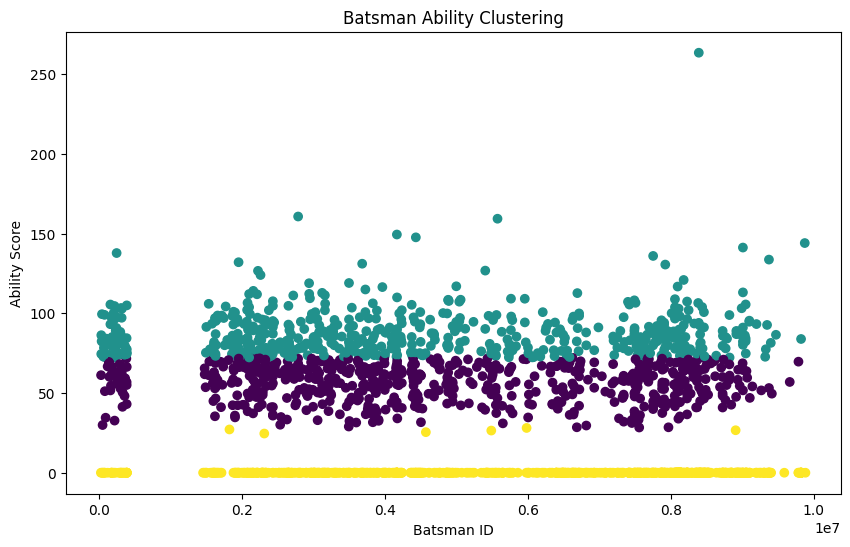

Threshold for a good batsman: 72.26924665809945


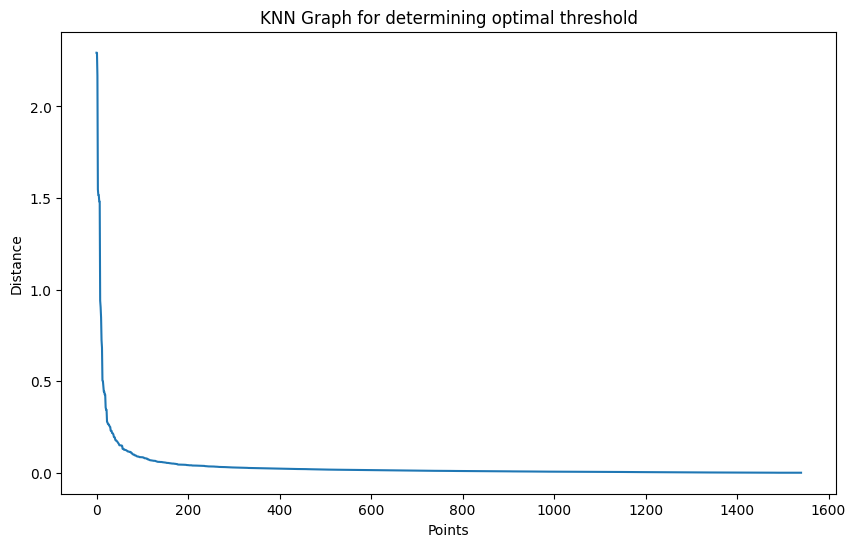

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


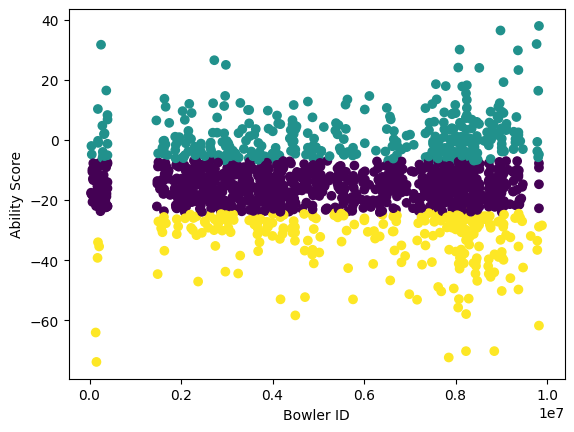

Threshold for a good bowler (percentile-based): -7.311099190600343


<ipython-input-127-92fbe7963032>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{team1_col}/{team2_col}'] = division_result
<ipython-input-127-92fbe7963032>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{team1_col}-{team2_col}'] = train_df[team1_col] - train_df[team2_col]
<ipython-input-127-92fbe7963032>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [ ]:
# to fully process train dataset
df_train = give_final_file(df_train, match_df, batsman_df, bowler_df)

271it [00:07, 34.13it/s]
271it [00:00, 2881.57it/s]
271it [00:12, 22.32it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


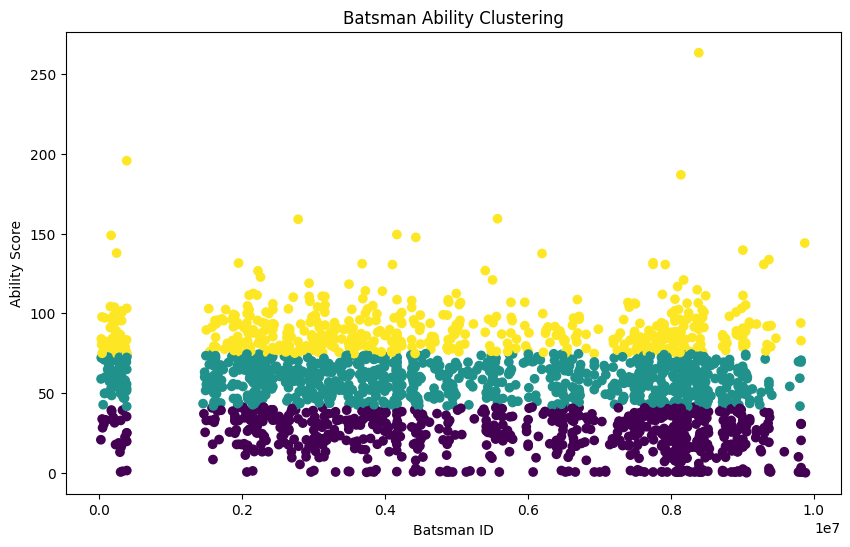

Threshold for a good batsman: 74.65245824516998


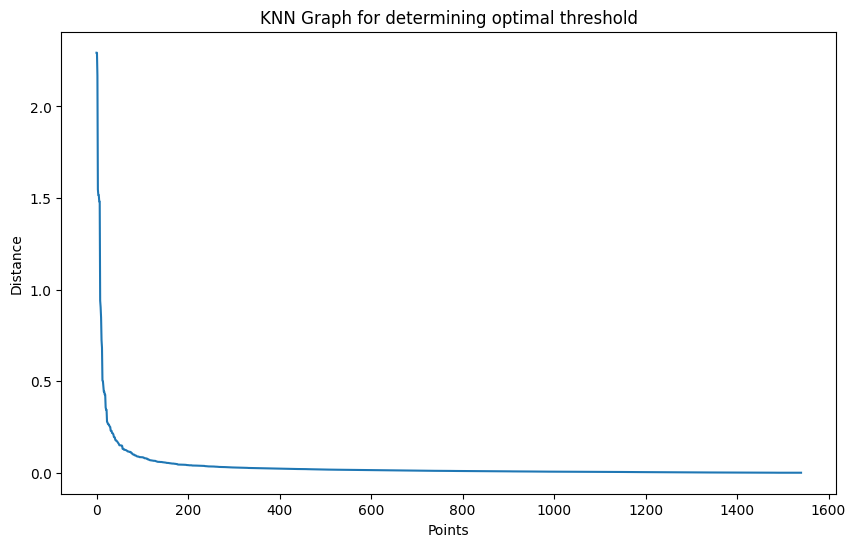

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


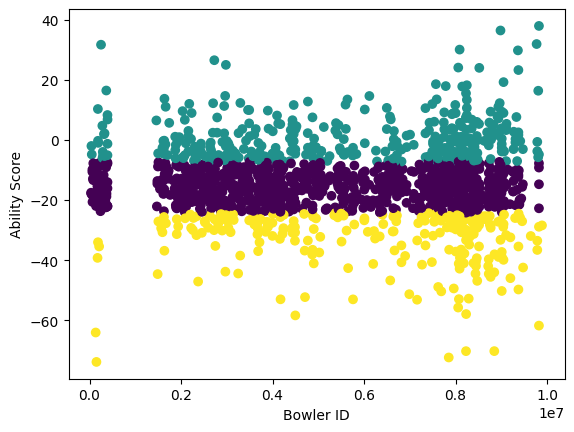

Threshold for a good bowler (percentile-based): -7.311099190600343


<ipython-input-127-92fbe7963032>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{team1_col}/{team2_col}'] = division_result
<ipython-input-127-92fbe7963032>:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df[f'{team1_col}-{team2_col}'] = train_df[team1_col] - train_df[team2_col]
<ipython-input-127-92fbe7963032>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

In [ ]:
# to fully process test dataset
test_data = give_final_file(test_data, match_df, batsman_df, bowler_df)

In [ ]:
def find_nan_columns(df):
    nan_counts = df.isna().sum()
    nan_columns = nan_counts[nan_counts > 0]
    return nan_columns

# Apply the function
nan_columns = find_nan_columns(df_train)

# Print the columns with NaN values and their counts
print(nan_columns)

team1only_avg_runs_last15                                           21
ground_avg_runs_last15                                              53
victory_by_runs_team1                                               15
victory_by_runs_team2                                               26
victory_by_wickets_team1                                            10
victory_by_wickets_team2                                             3
inning2_avg_wickets_team1/inning2_avg_wickets_team2                  6
team1_runs_avg_inning1_venue/team2_runs_avg_inning1_venue          318
team1_wickets_avg_inning2_venue/team2_wickets_avg_inning2_venue    318
victory_by_runs_team1-victory_by_runs_team2                         40
victory_by_wickets_team1-victory_by_wickets_team2                   13
dtype: int64


In [ ]:
nan2 = find_nan_columns(test_data)
print(nan2)

team1only_avg_runs_last15                                           7
ground_avg_runs_last15                                             10
victory_by_runs_team1                                              11
victory_by_runs_team2                                               8
victory_by_wickets_team1                                            3
victory_by_wickets_team2                                            4
inning2_avg_wickets_team1/inning2_avg_wickets_team2                 1
team1_runs_avg_inning1_venue/team2_runs_avg_inning1_venue          83
team1_wickets_avg_inning2_venue/team2_wickets_avg_inning2_venue    83
victory_by_runs_team1-victory_by_runs_team2                        18
victory_by_wickets_team1-victory_by_wickets_team2                   7
dtype: int64


In [ ]:
import pandas as pd

def find_zero_columns(df):
    """
    Find columns with zero values and count the number of zeros in each column.

    Parameters:
    df (pd.DataFrame): The DataFrame to check.

    Returns:
    pd.Series: A Series with the count of zeros in each column that has at least one zero.
    """
    zero_counts = (df == 0).sum()
    zero_columns = zero_counts[zero_counts > 0]
    return zero_columns

# Apply the function
zero_columns = find_zero_columns(df_train)

# Print the columns with zero values and their counts
print(zero_columns)

winner                                                             477
toss winner                                                        617
toss decision                                                      617
lighting                                                           243
team1_winp_team2_last15                                            356
                                                                  ... 
team1_wickets_avg_inning2_venue-team2_wickets_avg_inning2_venue     30
team1_venue_wins                                                   175
team2_venue_wins                                                   164
team1_venue_wins_last5                                             186
team2_venue_wins_last5                                             173
Length: 93, dtype: int64


In [ ]:
zeros2 = find_zero_columns(test_data)
print(zeros2)

toss winner                                                                    178
toss decision                                                                  178
lighting                                                                        85
team_count_50runs_last15                                                        12
team1_winp_team2_last15                                                        103
                                                                              ... 
team1_batting_chance_winning_FormVise-team2_batting_chance_winning_FormVise      2
team1_venue_wins                                                                85
team2_venue_wins                                                                90
team1_venue_wins_last5                                                          85
team2_venue_wins_last5                                                          91
Length: 101, dtype: int64


In [ ]:
# UPTIL HERE ALL OF THE TRAIN DATA HAS BEEN PROCESSED
# SO SAVING IT IN A CSV IN DRIVE
df_train.to_csv('/content/drive/MyDrive/AmEx/processed_train_f.csv', index=False)

# UPTIL HERE ALL OF THE TEST DATA HAS BEEN PROCESSED
# SO SAVING IT IN A CSV IN DRIVE
test_data.to_csv('/content/drive/MyDrive/AmEx/processed_test_f.csv', index=False)

In [ ]:
print(df_train.shape, test_data.shape, batsman_df.shape, bowler_df.shape, match_df.shape)

(948, 141) (271, 140) (24483, 20) (18539, 18) (1689, 30)


#----- MODEL -----

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/AmEx/processed_train_f.csv')
test_data = pd.read_csv('/content/drive/MyDrive/AmEx/processed_test_f.csv')

In [ ]:
print(df_train.shape, test_data.shape)

(948, 99) (271, 98)


In [ ]:
# cleaning the train data of unwanted columns before applying model
if 'pred_winner_id' in df_train.columns:
    df_train = df_train.drop(columns='pred_winner_id')
if 'pred_winner_score' in df_train.columns:
    df_train = df_train.drop(columns='pred_winner_score')
if 'pred_winner' in df_train.columns:
    df_train = df_train.drop(columns='pred_winner')
if 'dataset_type' in df_train.columns:
    df_train = df_train.drop(columns='dataset_type')

# cleaning the test data of unwanted columns before applying model
if 'pred_winner_id' in test_data.columns:
  test_data = test_data.drop(columns = 'pred_winner_id')
if 'pred_winner_score' in test_data.columns:
  test_data = test_data.drop(columns = 'pred_winner_score')
if 'pred_winner' in test_data.columns:
  test_data = test_data.drop(columns = 'pred_winner')
if 'dataset_type' in test_data.columns:
  test_data = test_data.drop(columns = 'dataset_type')

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 3.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Assuming df_train is your DataFrame and 'winner' is your target variable
# Example: df_train = pd.read_csv('your_data.csv')

# Filter numerical columns
numerical_cols = [col for col in df_train.columns if df_train[col].dtype in ['int64', 'float64']]

# Include the 'winner' column in the filtered dataframe
df_filtered = df_train[numerical_cols].copy()
df_filtered['winner'] = df_train['winner']

# Separate features and target variable
features = df_filtered.drop(['match id', 'team1_id', 'team2_id', 'winner', 'ground_id'], axis=1)
target = df_filtered['winner']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Create and train the XGBoost model for feature selection
xgb_model = XGBClassifier(n_estimators=50)  # Reduced n_estimators for faster execution
xgb_model.fit(X_train, y_train)

# Get feature importances and select top 20 features
feature_importances = xgb_model.feature_importances_
top_20_features = np.argsort(feature_importances)[-20:]

X_train_top20 = X_train.iloc[:, top_20_features]
X_test_top20 = X_test.iloc[:, top_20_features]

# Function to create a snapshot ensemble model for XGBoost
def snapshot_ensemble_xgboost(X_train, y_train, n_snapshots=3, snapshot_interval=5, epochs=20):  # Reduced parameters for faster execution
    snapshots = []
    for i in range(n_snapshots):
        xgb_model = XGBClassifier(n_estimators=(i + 1) * snapshot_interval)
        xgb_model.fit(X_train, y_train)
        snapshots.append(xgb_model)
    return snapshots

# Train snapshot ensemble models
snapshots = snapshot_ensemble_xgboost(X_train_top20, y_train)

# Create and train the CatBoost model with L1 and L2 regularization
catboost_model = CatBoostClassifier(depth=6, l2_leaf_reg=5, iterations=100, learning_rate=0.1, random_seed=42, verbose=0)  # Reduced iterations and depth for faster execution
catboost_model.fit(X_train_top20, y_train, verbose=0)

# Stacking ensemble
estimators = [
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=50)),  # Reduced n_estimators for faster execution
    ('catboost', CatBoostClassifier(depth=6, l2_leaf_reg=5, iterations=100, learning_rate=0.1, random_seed=42, verbose=0))  # Reduced iterations and depth for faster execution
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)

# Train the stacking model
stacking_model.fit(X_train_top20, y_train)

# Evaluate the model using cross-validation
cv_scores = cross_val_score(stacking_model, X_train_top20, y_train, cv=3, scoring='accuracy')  # Reduced CV folds for faster execution
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")

# Evaluate the model on the test set
test_accuracy = stacking_model.score(X_test_top20, y_test)
print(f"Test set accuracy: {test_accuracy}")

# Train the stacking model on the entire training data
stacking_model.fit(X_train_top20, y_train)

# Evaluate the model on the entire training data
train_accuracy = stacking_model.score(X_train_top20, y_train)
print(f"Training set accuracy: {train_accuracy}")

Cross-validation scores: [0.75494071 0.7944664  0.73809524]
Mean cross-validation score: 0.7625007842399146
Test set accuracy: 0.7210526315789474
Training set accuracy: 0.9129287598944591


In [ ]:
X = df_filtered[features.columns]
X_top20 = X.iloc[:, top_20_features]
df_train['pred_winner'] = stacking_model.predict(X_top20)
df_train['pred_winner_score'] = stacking_model.predict_proba(X_top20)[:, 1]
df_train['pred_winner_id'] = df_train.apply(lambda row: row['team1_id'] if row['pred_winner'] == 1 else row['team2_id'], axis=1)
df_train.shape

(948, 102)

In [ ]:
numerical_cols_test = [col for col in test_data.columns if test_data[col].dtype in ['int64', 'float64']]
df_test_filtered = test_data[numerical_cols_test].copy()
X_test_full = df_test_filtered[features.columns]
X_test_top20 = X_test_full.iloc[:, top_20_features]
test_data['pred_winner'] = stacking_model.predict(X_test_top20)
test_data['pred_winner_score'] = stacking_model.predict_proba(X_test_top20)[:, 1]
test_data['pred_winner_id'] = test_data.apply(lambda row: row['team1_id'] if row['pred_winner'] == 1 else row['team2_id'], axis=1)
test_data.shape

(271, 101)

In [ ]:
df_train['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [ ]:
algo_name = 'XGBClassifier;CatBoostClassifier'
is_ensemble = 'yes'
n_trees = '50;100'
depth = '5;6'
lr = '0.1;0.1'

In [ ]:
import pandas as pd
import numpy as np

# Extract XGBoost and CatBoost models from the stacking classifier
xgb_model = stacking_model.named_estimators_['xgb']
catboost_model = stacking_model.named_estimators_['catboost']

# Get feature importances from XGBoost
xgb_feature_importances = xgb_model.feature_importances_

# Get feature importances from CatBoost
catboost_feature_importances = catboost_model.get_feature_importance()

# Average the feature importances from both models
average_feature_importances = (xgb_feature_importances + catboost_feature_importances) / 2

# Create a DataFrame with feature names and their averaged importances
df_feat_importance = pd.DataFrame({
    'feat_name': X_train_top20.columns.tolist(),
    'model_feat_imp_train': average_feature_importances
}).sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(40)

# Display the top 10 important features
print(df_feat_importance)

                                 feat_name  model_feat_imp_train
0   team1_bowling_chance_winning_VenueVise              6.672485
1          team1_wickets_avg_inning2_venue              6.303057
2                        team2_won_in_past              3.356956
3   team2_bowling_chance_winning_VenueVise              3.154440
4             team2_batting_chance_winning              3.087790
5                        top_bowler2_team2              2.695408
6                        top_bowler2_team1              2.693456
7                team1only_avg_runs_last15              2.437390
8             team1_batting_chance_winning              2.293457
9                   inning1_avg_runs_team1              2.124478
10            team1_runs_avg_inning1_venue              1.991125
11                      top_batsman1_team1              1.925879
12            team2_runs_avg_inning2_venue              1.886455
13                    team1_quality_player              1.786425
14                victory

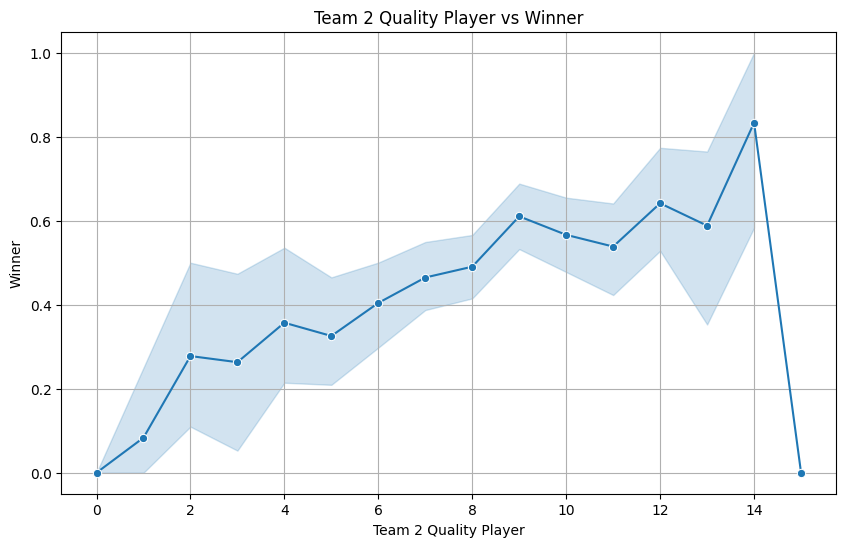

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort the DataFrame by 'team1_quality_player'
df_train_sorted = df_train.sort_values('team1_quality_player')

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_train_sorted, x='team1_quality_player', y='winner', marker='o')
plt.title('Team 2 Quality Player vs Winner')
plt.xlabel('Team 2 Quality Player')
plt.ylabel('Winner')
plt.grid(True)
plt.show()

In [ ]:
# Count the number of rows where 'team1_quality_player' > 14
count = df_train[df_train['team1_quality_player'] > 14].shape[0]

print(f"Number of rows with 'team1_quality_player' > 14: {count}")

Number of rows with 'team1_quality_player' > 14: 1


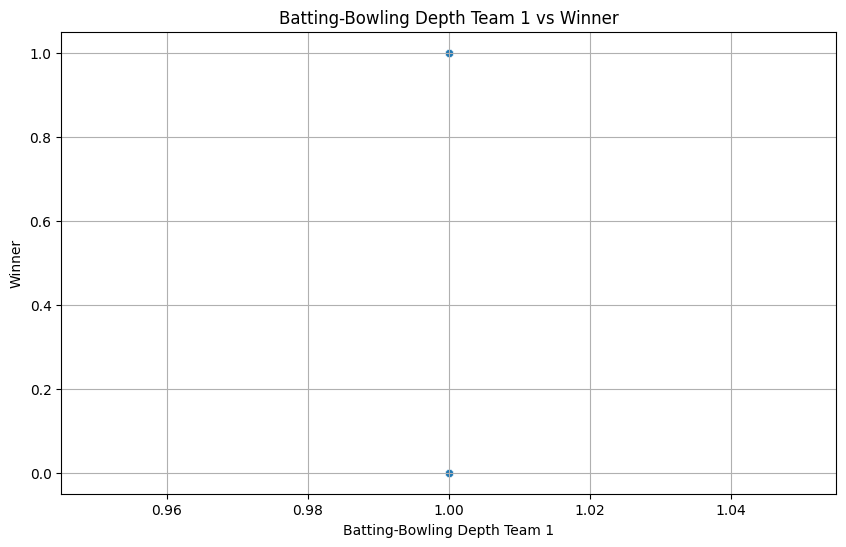

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the DataFrame by 'batting_bowling_depth_team1'
df_train_sorted = df_train.sort_values('batting-bowling_depth_team1')

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='batting-bowling_depth_team1', y='winner')
plt.title('Batting-Bowling Depth Team 1 vs Winner')
plt.xlabel('Batting-Bowling Depth Team 1')
plt.ylabel('Winner')
plt.grid(True)
plt.show()

In [ ]:
df_train['batting-bowling_depth_team1'].value_counts()

batting-bowling_depth_team1
1.0    948
Name: count, dtype: int64

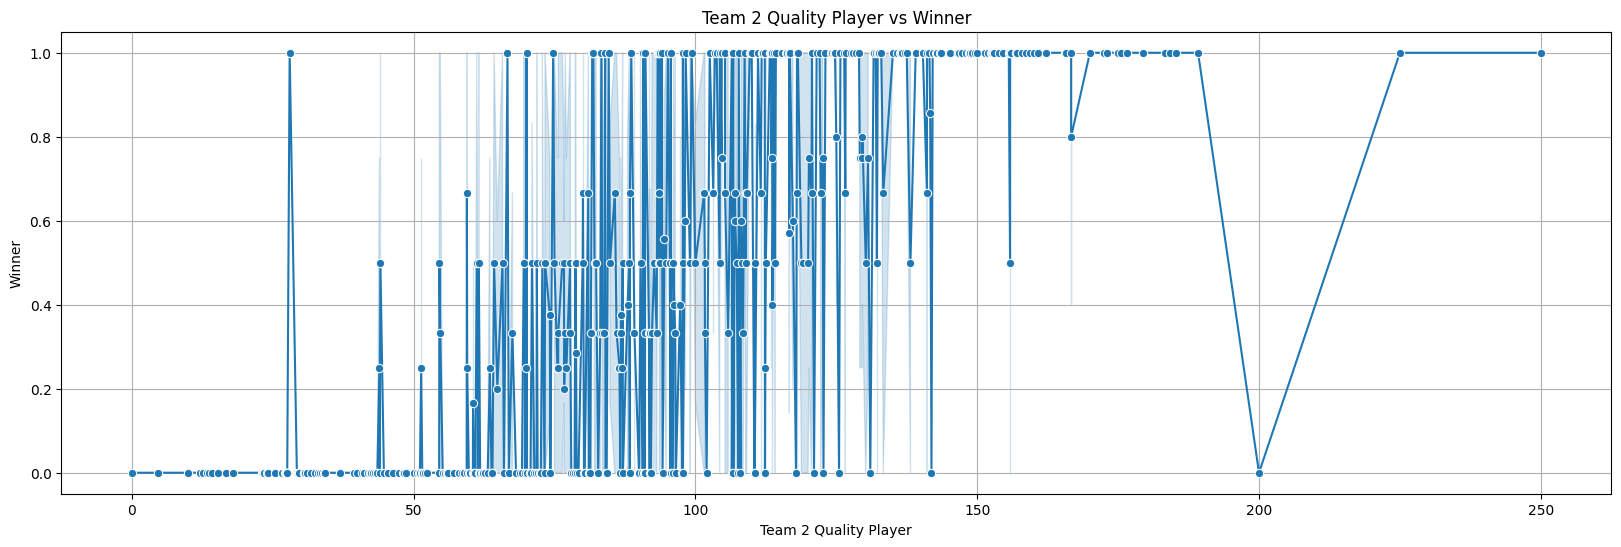

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sort the DataFrame by 'team1_quality_player'
df_train_sorted = df_train.sort_values('team1_bowling_chance_winning_VenueVise')

# Plotting
plt.figure(figsize=(20, 6))
sns.lineplot(data=df_train_sorted, x='team1_bowling_chance_winning_VenueVise', y='winner', marker='o')
plt.title('Team 2 Quality Player vs Winner')
plt.xlabel('Team 2 Quality Player')
plt.ylabel('Winner')
plt.grid(True)
plt.show()

In [ ]:
df_file1 = pd.concat([test_data[['match id','dataset_type','pred_winner_id','pred_winner_score',] + list(df_feat_importance['feat_name'].head(10))], \
                     df_train[['match id','dataset_type','pred_winner_id','pred_winner_score',] + list(df_feat_importance['feat_name'].head(10))]])

renaming_dict = {}
for i,col in enumerate(list(df_feat_importance['feat_name'].head(10))):
    renaming_dict[col] = f'indep_feat_id{i+1}'
df_file1.rename(columns=renaming_dict, inplace=True)

for i in range(1,11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [ ]:
df_file1['pred_winner_id'] = df_file1['pred_winner_id'].astype('int64')
print(df_file1.shape)
df_file1.head()

(1219, 19)


,match id,dataset_type,pred_winner_id,pred_winner_score,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr
0,9250275,r1,90,0.292358,0.000000,0.000000,0.400000,0.000000,0.000000,64.083333,74.000000,0.000000,0.000000,0.000000,XGBClassifier;CatBoostClassifier,yes,50;100,5;6,0.1;0.1
1,9262189,r1,36084,0.823286,122.222222,7.333333,0.434783,100.000000,72.301762,53.043784,58.661887,151.285714,104.673762,165.857143,XGBClassifier;CatBoostClassifier,yes,50;100,5;6,0.1;0.1
2,9128776,r1,30428,0.846026,157.894737,10.000000,0.578947,110.526316,122.912621,59.597714,55.966552,171.066667,115.681919,176.684211,XGBClassifier;CatBoostClassifier,yes,50;100,5;6,0.1;0.1
3,9586919,r1,36112,0.150491,91.764706,6.000000,0.481481,122.352941,115.118790,52.720000,56.865385,166.000000,91.801317,176.066667,XGBClassifier;CatBoostClassifier,yes,50;100,5;6,0.1;0.1
4,9128538,r1,30414,0.763332,105.263158,6.000000,0.625000,0.000000,0.000000,58.762174,54.129091,169.933333,118.197776,182.913043,XGBClassifier;CatBoostClassifier,yes,50;100,5;6,0.1;0.1


In [ ]:
print(df_feat_importance)

                                feat_name  model_feat_imp_train
0  team1_bowling_chance_winning_VenueVise              6.672485
1         team1_wickets_avg_inning2_venue              6.303057
2                       team2_won_in_past              3.356956
3  team2_bowling_chance_winning_VenueVise              3.154440
4            team2_batting_chance_winning              3.087790
5                       top_bowler2_team2              2.695408
6                       top_bowler2_team1              2.693456
7               team1only_avg_runs_last15              2.437390
8            team1_batting_chance_winning              2.293457
9                  inning1_avg_runs_team1              2.124478


In [ ]:
feature_desc = {
    'team1_bowling_chance_winning_VenueVise': 'Chance of Team 1 winning based on their bowling performance at this venue',
    'team1_wickets_avg_inning2_venue': 'Average wickets taken by Team 1 in the second innings at this venue',
    'team2_won_in_past': 'Number of times Team 2 has won in past encounters',
    'team2_bowling_chance_winning_VenueVise': 'Chance of Team 2 winning based on their bowling performance at this venue',
    'team2_batting_chance_winning': 'Chance of Team 2 winning based on their batting performance',
    'top_bowler2_team2': 'Performance rating of the second best bowler from Team 2',
    'top_bowler2_team1': 'Performance rating of the second best bowler from Team 1',
    'team1only_avg_runs_last15': 'Average runs scored by Team 1 only in the last 15 matches',
    'team1_batting_chance_winning': 'Chance of Team 1 winning based on their batting performance',
    'inning1_avg_runs_team1': 'Average runs scored by Team 1 in the first innings'
}

In [ ]:
# df_feat_importance.rename(index={0:'feat_id'}, inplace=True)
df_file2 = df_feat_importance
df_file2['feat_id'] = [i+1 for i in df_file2.index]
df_file2['feat_rank_train'] = [i+1 for i in df_file2.index]
df_file2 = df_file2.set_index('feat_id')
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)
df_file2

,feat_name,model_feat_imp_train,feat_rank_train,feat_description
feat_id,,,,
1,team1_bowling_chance_winning_VenueVise,6.672485,1,Chance of Team 1 winning based on their bowlin...
2,team1_wickets_avg_inning2_venue,6.303057,2,Average wickets taken by Team 1 in the second ...
3,team2_won_in_past,3.356956,3,Number of times Team 2 has won in past encounters
4,team2_bowling_chance_winning_VenueVise,3.154440,4,Chance of Team 2 winning based on their bowlin...
5,team2_batting_chance_winning,3.087790,5,Chance of Team 2 winning based on their battin...
6,top_bowler2_team2,2.695408,6,Performance rating of the second best bowler f...
7,top_bowler2_team1,2.693456,7,Performance rating of the second best bowler f...
8,team1only_avg_runs_last15,2.437390,8,Average runs scored by Team 1 only in the last...
9,team1_batting_chance_winning,2.293457,9,Chance of Team 1 winning based on their battin...


In [ ]:
df_file1.rename(columns={'pred_winner_id': 'win_pred_team_id'}, inplace=True)
df_file1.rename(columns={'pred_winner_score': 'win_pred_score'}, inplace=True)

In [ ]:
df_file1.to_csv('/content/drive/MyDrive/AmEx/file1.csv', index=False)
df_file2.to_csv('/content/drive/MyDrive/AmEx/file2.csv', index=False)

In [ ]:
df_train.columns.tolist()

['match id',
 'team1',
 'team1_id',
 'team1_roster_ids',
 'team2',
 'team2_id',
 'team2_roster_ids',
 'winner',
 'toss winner',
 'toss decision',
 'venue',
 'city',
 'match_dt',
 'lighting',
 'series_name',
 'season',
 'ground_id',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_roster_ids_bowlers',
 'team2_roster_ids_bowlers',
 'top_bowler1_team1',
 'top_bowler2_team1',
 'top_bowler3_team1',
 'top_bowler1_team2',
 'top_bowler2_team2',
 'top_bowler3_team2',
 'top_batsman1_team1',
 'top_batsman2_team1',
 'top_batsman3_team1',
 'top_batsman1_team2',
 'top_batsman2_team2',
 'top_batsman3_team2',
 'Sum_restBowlerAbility_team1',
 'Sum_restBowlerAbility_team2',
 'Sum_restBatsmanAbility_team1',
 'Sum_restBatsmanAbility_team2',
 'avg_inning1_runs_venue',
 'avg_inning2_runs_venue',
 'avg_inning1_wickets_venue',
 'avg_inning2_wickets_venue',
 'venue_based_toss_decision_winner_avg',
 'victory_by_runs_tea